3d XRD feature extraction with fourier-based background subtraction

In [13]:
# https://stackoverflow.com/questions/35282456/find-local-maximums-in-numpy-array
from scipy.signal import argrelextrema
from scipy.ndimage.filters import gaussian_filter as gf
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload

from xrdc.datasets import d3d
from xrdc import featurization as feat
from xrdc import source_separation as sep
from xrdc.dataproc.dataproc.operations import hitp
from xrdc import visualization as vis

In [2]:
%pdb

Automatic pdb calling has been turned ON


In [2]:
from pymatgen.core.lattice import Lattice
from pymatgen.core.structure import Structure
from pymatgen.analysis.diffraction.xrd import XRDCalculator

In [3]:
from xrdc import peak_fitting as pf
reload(pf)

/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig


<module 'xrdc.peak_fitting' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/peak_fitting.py'>

In [4]:
debug = False

In [5]:
# %pdb

## 3D feature extraction

In [4]:
def get_coords(dgrid):
    coords = np.array([dgrid.coord(ii + 1) for ii in range(177)])
    return coords

swap3d = lambda arr: np.einsum("ijk->kij", arr)

def csim3d(activations_n1):
    #activations_n1 = swap3d(activations_n1)
    tmp = np.einsum("kij, klm->ijlm", activations_n1, activations_n1)

    norm = np.linalg.norm(activations_n1, axis = 0)

    norm4d = np.einsum("ij, kl->ijkl", norm, norm)

    tmp_csim = tmp / (norm4d + 1e-30)
    return tmp_csim

def gridstack(arr4d):
    return np.vstack(np.dstack(np.transpose(arr4d, (1, 0, 2, 3))))

def plot_clusters_grid(coords, clust, nclust):
    import matplotlib
    dim = coords.max()
    coordi = coords - 1
    hues = [float(float(x)/float(nclust)) for x in range(1,nclust+1)]
    cg = cluster_grid = np.zeros(shape = (dim,dim,3))
    for k, (x, y) in enumerate(coordi):
        cluster = clust[k]
        cluster_grid[x, y] = matplotlib.colors.hsv_to_rgb([hues[cluster],1,1])
#     if debug:
#         print(coords)

#     fig = plt.figure()
#     fig.tight_layout()
    start, end = nclust - 1, nclust
    Big_labels = []
    Big_labels.append(clust)
    plt.imshow(cg)
    
def rmap(arr):
    """
    Map feature indices to random floats for visualization (temporary hack)
    """
    imax = arr.max()
    arr = arr.copy().astype(float)

    for i in range(1, imax + 1):
        new = np.random.random()
        arr[arr == i] = new
    return arr
 
# merge eventually into featurization.peakfit_featurize, needs to be more general to handle both 2 and 3-d arrays
def peakfit_featurize(patterns_pp, fitlists, size_thresh = 5, thicken_ax0 = 1, normf = feat.norm3d):
    #patterns_pp = gf(patterns, (1, 1.7))
    labeled, feature_masks, activations, norm_, activations_n1 = feat.get_ridge_features(
        patterns_pp,
        smooth_ax1 = 1,
        smooth_ax0 = thicken_ax0, threshold_percentile = 50, thicken = True, size_thresh = size_thresh, bgsub=False,
        log_scale_features = False, fwhm_finder=feat.fwhm_finder, do_flood_thicken = False, max_size_flood = 20,
        thicken_ax0 = 1,
        thicken_ax1 = 0, flood_threshold=.95, smooth_factor_ax1 = .125, fitlists = fitlists,
    peakwidth = 1, normf = normf)
    return labeled, feature_masks, activations, norm_, activations_n1

# heatmap overlayed with binary mask
def overlay_mask(img, mask, **kwargs):
    grayscale = 1 - mask
    alpha = mask
    rgb_img = np.dstack((grayscale, (grayscale), grayscale, (alpha)))
    plt.imshow(np.log(1 + img), cmap = 'jet', **kwargs)
    plt.imshow(rgb_img, cmap = 'Greys', **kwargs)

In [5]:
# multiply normalized patterns by 1000 so that the peak-finding routine will play nice
patterns = m3d = 1000 * d3d.get_data().copy()
#patterns = m3d_agglom# = m3d.reshape(15, 15, -1, 2).sum(axis = 3)

TODO run this on slow_T instead of patterns

In [6]:
reload(pf)

/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig


<module 'xrdc.peak_fitting' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/peak_fitting.py'>

In [7]:
from xrdc import source_separation as sep
background, fast_q, slow_T, fast_T = sep.separate_signal(patterns, background_after_filter = True,
                                                    threshold = 50, smooth_q = 1.7, bg_fill_method = 'simple')

# slow_q, fast_q, slow_T, fast_T = sep.separate_signal(patterns)

# #background = sep.get_background(patterns, threshold = 25, smooth_q = 1.7, method = 'simple')
# background = sep.get_background(slow_T, threshold = 25, smooth_q = 1.7, bg_fill_method = 'simple')

fsub_stop_2d = pf.curvefit_2d(patterns, background = background,
                         noise_estimate = fast_T, stdratio_threshold = 2)



(0, 0, 0)
numBlocks: 92, dataPts/Block: 8.695652173913043
[  0.  31.  87. 261. 304. 318. 377. 423. 516. 540. 655. 747. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  31.,  87., 261., 304., 318., 377., 423., 516., 540., 655.,
       747., 799.])}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a single process
Peak at 9, start iteration with error = 0.11790699176191535
2.463489162621338
Peak at 9, iteration 0: error = 0.1221699904232323
2.5052976421626827
Peak at 9, iteration 1: error = 0.010986694154867057
0.2946871835649092
Peak at 59, start iteration with error = 0.2212340743795516
2.0544147681098877
Peak at 59, iteration 0: error = 0.054327657173900465
0.152881260472367
Peak at 137, start iteration with error = 0.14468900800532997
1.5221455424670427
Peak at 286, start iteration with error = 0.5366578102629239
3.7895929440693363
Peak at 286, iteration 0: error = 0.08034297896992984
0.

numBlocks: 71, dataPts/Block: 11.267605633802816
[  0.  27.  85. 261. 342. 457. 595. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  27.,  85., 261., 342., 457., 595., 799.])}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a single process
Peak at 10, start iteration with error = 0.12715448239021535
8.935343572544294
Peak at 10, iteration 0: error = 0.10143120578191779
7.002693501611521
Peak at 10, iteration 1: error = 0.012343531839475909
1.0381047983050675
Peak at 59, start iteration with error = 0.22762401716538372
4.662214969842486
Peak at 59, iteration 0: error = 0.05746867396970794
0.3376389307900215
Peak at 131, start iteration with error = 0.19283649854528306
0.5991665696688605
Peak at 287, start iteration with error = 0.5482607660071764
5.7599062647008346
Peak at 287, iteration 0: error = 0.27394733449482506
0.8379855340215335
Peak at 389, start iteration with error = 0.1201987

Peak at 137, iteration 1: error = 0.09814008278451378
2.4047383782994975
Peak at 137, iteration 2: error = 0.07223405839172493
Peak at 168, start iteration with error = 0.11149303292814253
4.394890606204762
Peak at 168, iteration 0: error = 0.12715002147701
2.454488819997577
Peak at 168, iteration 1: error = 0.00692950109439907
0.17453789600747197
Peak at 199, start iteration with error = 0.11849519571351347
5.183346383671385
Peak at 199, iteration 0: error = 0.07641176719433718
2.2773073299322264
Peak at 199, iteration 1: error = 0.022812590444031673
0.7240492960367594
Peak at 241, start iteration with error = 0.16851879653141577
21.596311980976697
Peak at 241, iteration 0: error = 0.127084614351678
14.295817186115709
Peak at 241, iteration 1: error = 0.012552426069780121
1.6327619527772483
Peak at 287, start iteration with error = 0.4074155500624476
11.410431243072875
Peak at 287, iteration 0: error = 0.056360075974080506
0.34296758018205326
Peak at 308, start iteration with error = 

Peak at 605, iteration 0: error = 0.03091612083018006
2.3064682713735754
Peak at 605, iteration 1: error = 0.018210644251619564
1.1987494012601743
Peak at 718, start iteration with error = 0.2683729394519609
16.80657280925129
Peak at 718, iteration 0: error = 0.05298428282021887
1.2283770620696324
    ----Saving data for block between 1.00 - 84.00
    ----Saving data for block between 85.00 - 263.00
    ----Saving data for block between 264.00 - 373.00
    ----Saving data for block between 374.00 - 456.00
    ----Saving data for block between 457.00 - 567.00
    ----Saving data for block between 568.00 - 650.00
    ----Saving data for block between 651.00 - 798.00
done
numBlocks: 79, dataPts/Block: 10.126582278481013
[  0.  84. 139. 342. 456. 566. 608. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  84., 139., 342., 456., 566., 608., 799.])}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
runnin

Peak at 68, start iteration with error = 0.24296333720750554
11.964589407067793
Peak at 68, iteration 0: error = 0.07821827295173647
1.3253275115193053
Peak at 126, start iteration with error = 0.2956893806318649
9.686498900129852
Peak at 126, iteration 0: error = 0.12226562057022827
1.2359486857610318
Peak at 141, start iteration with error = 0.22966595374949916
3.3637249896339694
Peak at 141, iteration 0: error = 0.08240475384492846
0.5206370855438505
Peak at 168, start iteration with error = 0.18791369049403037
13.03149215865318
Peak at 168, iteration 0: error = 0.06308395297297596
1.8220711712022728
Peak at 199, start iteration with error = 0.17125505768483174
8.429333068772609
Peak at 199, iteration 0: error = 0.17467305920388113
7.378198575924394
Peak at 199, iteration 1: error = 0.015351365014769821
0.9003760420309277
Peak at 242, start iteration with error = 0.13481118483492402
3.0949301595509393
Peak at 242, iteration 0: error = 0.05432574782480453
0.7951378124715404
Peak at 3

Peak at 168, iteration 0: error = 0.09157898999601695
4.341188890602195
Peak at 168, iteration 1: error = 0.011014436143419333
0.655631172292974
Peak at 199, start iteration with error = 0.18776969944012312
14.502887173906942
Peak at 199, iteration 0: error = 0.2003735521085014
13.217814467238657
Peak at 199, iteration 1: error = 0.01794027850330462
1.523542138415517
Peak at 241, start iteration with error = 0.13330320588674358
10.382921897644874
Peak at 241, iteration 0: error = 0.11004014494779801
4.622528814743752
Peak at 241, iteration 1: error = 0.015775938400072107
0.709341190168141
Peak at 287, start iteration with error = 0.3845075284803361
19.89511170928145
Peak at 287, iteration 0: error = 0.08664753563936765
0.9145260084200671
Peak at 303, start iteration with error = 0.4410856512869551
24.345111130756695
Peak at 303, iteration 0: error = 0.36625456234920806
15.87796604408667
Peak at 303, iteration 1: error = 0.07813432448830256
3.4997402801378743
Peak at 303, iteration 2: e

Peak at 717, iteration 0: error = 0.07490875960475127
1.0310597810499347
Peak at 778, start iteration with error = 0.23021689849619806
3.473214586033572
Peak at 778, iteration 0: error = 0.03989748041462384
0.4559720610599387
    ----Saving data for block between 1.00 - 27.00
    ----Saving data for block between 28.00 - 89.00
    ----Saving data for block between 90.00 - 116.00
    ----Saving data for block between 117.00 - 258.00
    ----Saving data for block between 259.00 - 305.00
dropping block with index 5
    ----Saving data for block between 312.00 - 373.00
    ----Saving data for block between 374.00 - 467.00
    ----Saving data for block between 468.00 - 566.00
dropping block with index 9
    ----Saving data for block between 578.00 - 654.00
    ----Saving data for block between 655.00 - 768.00
    ----Saving data for block between 769.00 - 798.00
done
numBlocks: 83, dataPts/Block: 9.63855421686747
[  0.  28.  87. 256. 314. 374. 461. 571. 655. 799.]
True
Experimental Info use

Peak at 718, start iteration with error = 0.3611176663069849
19.51537913769467
Peak at 718, iteration 0: error = 0.10160289999775769
2.1725620999909525
Peak at 718, iteration 1: error = 0.09448091276856749
2.1498350403022104
Peak at 718, iteration 2: error = 0.09447881600190643
    ----Saving data for block between 1.00 - 87.00
    ----Saving data for block between 88.00 - 136.00
    ----Saving data for block between 137.00 - 376.00
    ----Saving data for block between 377.00 - 465.00
    ----Saving data for block between 466.00 - 545.00
    ----Saving data for block between 546.00 - 649.00
    ----Saving data for block between 650.00 - 798.00
done
numBlocks: 79, dataPts/Block: 10.126582278481013
[  0.  84. 140. 331. 350. 467. 546. 608. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  84., 140., 331., 350., 467., 546., 608., 799.])}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a singl

/home/ollie/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Peak at 249, start iteration with error = 0.14622867031053194
2.9342075875330904
Peak at 249, iteration 0: error = 0.06479472963580862
0.4692082982614701
Peak at 302, start iteration with error = 0.6091358215419975
11.300246544550657
Peak at 302, iteration 0: error = 0.10849200703877383
0.7951183345643045
Peak at 321, start iteration with error = 0.20903769787120893
6.471752926058229
Peak at 321, iteration 0: error = 0.16465119793897584
1.4976205611295648
Peak at 405, start iteration with error = 0.2022328867602512
18.562095670908153
Peak at 405, iteration 0: error = 0.17311142026801132
6.1257315559094
Peak at 405, iteration 1: error = 0.016511642905953396
0.8426130031818778
Peak at 437, start iteration with error = 0.13733857990641155
17.991108730855267
Peak at 437, iteration 0: error = 0.23155205282005184
18.25540094508919
Peak at 437, iteration 1: error = 0.009629615810570584
1.0226750093585757
Peak at 459, start iteration with error = 0.12350471631287466
6.186414852520877
Peak at 4

Peak at 125, start iteration with error = 0.29167620692706503
15.140486147521763
Peak at 125, iteration 0: error = 0.10966629931159937
3.344297538464603
Peak at 125, iteration 1: error = 0.052476906648083355
1.070772174861669
Peak at 168, start iteration with error = 0.1559541202372472
12.400462745665616
Peak at 168, iteration 0: error = 0.08758270357559558
3.1145762741602185
Peak at 168, iteration 1: error = 0.011728257528893503
0.5684947713644382
Peak at 199, start iteration with error = 0.18212899179253048
12.42373679567353
Peak at 199, iteration 0: error = 0.16817914111538845
9.840384134569867
Peak at 199, iteration 1: error = 0.014166577097234718
1.122428760117314
Peak at 241, start iteration with error = 0.1312101250004935
7.546488619154401
Peak at 241, iteration 0: error = 0.05193148684466067
2.2594910012322664
Peak at 241, iteration 1: error = 0.026583791714998098
0.9489101885227702
Peak at 287, start iteration with error = 0.4408316254222952
12.415268143582407
Peak at 287, ite

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 125, start iteration with error = 0.2461457743001033
16.58850802840997
Peak at 125, iteration 0: error = 0.0766615364514091
3.7639008950709147
Peak at 125, iteration 1: error = 0.051862922999333885
1.7862669548288415
Peak at 168, start iteration with error = 0.11275568245934212
10.539470510801154
Peak at 168, iteration 0: error = 0.10083812670121166
4.687342057707142
Peak at 168, iteration 1: error = 0.010111289212300149
0.6699031587577549
Peak at 199, start iteration with error = 0.14271073587233682
18.75855667540548
Peak at 199, iteration 0: error = 0.17859745617154651
19.99421714125523
Peak at 199, iteration 1: error = 0.009858190743941097
1.5717329895742427
Peak at 241, start iteration with error = 0.10808927019815864
11.121980700225658
Peak at 241, iteration 0: error = 0.10608615912761724
6.31446044607895
Peak at 241, iteration 1: error = 0.014181180422867526
0.9719737690521821
Peak at 28

Peak at 115, iteration 0: error = 0.05609983159402749
1.2717092214006591
Peak at 286, start iteration with error = 0.25483538285182195
8.242424790622762
Peak at 286, iteration 0: error = 0.07625608071672828
0.28424978044586935
Peak at 388, start iteration with error = 0.1245987493565887
6.715191109527667
Peak at 388, iteration 0: error = 0.13488432656765661
2.048572436952889
Peak at 388, iteration 1: error = 0.015628826876370416
0.4096195863471772
Peak at 531, start iteration with error = 0.2011787358924709
5.847400294715774
Peak at 531, iteration 0: error = 0.12340141459088752
0.89565711766007
Peak at 605, start iteration with error = 0.12348181991524633
5.833797506709191
Peak at 605, iteration 0: error = 0.04470570573172192
1.4278360791943985
Peak at 717, start iteration with error = 0.2800542875365627
10.132220115519072
Peak at 717, iteration 0: error = 0.08352271747736857
0.9727300131444104
    ----Saving data for block between 1.00 - 30.00
    ----Saving data for block between 31.

Peak at 604, start iteration with error = 0.10719522272766306
12.426309392563791
Peak at 604, iteration 0: error = 0.03409238045739775
3.2345393798853337
Peak at 604, iteration 1: error = 0.024347717390720548
2.3352327560706674
Peak at 604, iteration 2: error = 0.02050652879765841
Peak at 718, start iteration with error = 0.3822018524725898
25.804229537774514
Peak at 718, iteration 0: error = 0.07579791505398567
2.7300992943602456
Peak at 718, iteration 1: error = 0.04835524461644562
1.6053262702378852
    ----Saving data for block between 1.00 - 32.00
    ----Saving data for block between 33.00 - 87.00
    ----Saving data for block between 88.00 - 132.00
    ----Saving data for block between 133.00 - 334.00
dropping block with index 4
    ----Saving data for block between 353.00 - 462.00
    ----Saving data for block between 463.00 - 549.00
    ----Saving data for block between 550.00 - 650.00
    ----Saving data for block between 651.00 - 798.00
done
numBlocks: 94, dataPts/Block: 8.5

Peak at 168, start iteration with error = 0.14363808851937374
8.66291564433368
Peak at 168, iteration 0: error = 0.07733405654453579
2.151842509344952
Peak at 168, iteration 1: error = 0.009256976322272596
0.3660703786189434
Peak at 199, start iteration with error = 0.15973570123111777
10.976300337618044
Peak at 199, iteration 0: error = 0.1615383387676489
9.638856574407393
Peak at 199, iteration 1: error = 0.009793366147994753
0.8833062316683349
Peak at 241, start iteration with error = 0.12930930937943008
4.666122245233233
Peak at 241, iteration 0: error = 0.053890913673399134
1.3704035876080205
Peak at 301, start iteration with error = 0.617509333690878
16.418502898475797
Peak at 301, iteration 0: error = 0.17893586220455132
2.1051347618692717
Peak at 301, iteration 1: error = 0.06861930298868717
0.8325279625113473
Peak at 319, start iteration with error = 0.1503032136171997
10.564261291346922
Peak at 319, iteration 0: error = 0.1292129325236909
1.7783816828737722
Peak at 405, start

Peak at 301, iteration 0: error = 0.08802618827368569
2.9811703422257105
Peak at 301, iteration 1: error = 0.08033582577444025
2.6491177454054067
Peak at 301, iteration 2: error = 0.06736703565081796
Peak at 405, start iteration with error = 0.21106067176046672
15.009665280000984
Peak at 405, iteration 0: error = 0.09946832646194999
5.493584764105089
Peak at 405, iteration 1: error = 0.06569948700472773
3.233363100774824
Peak at 405, iteration 2: error = 0.037162318787166894
Peak at 551, start iteration with error = 0.23216220034585552
19.69591784078007
Peak at 551, iteration 0: error = 0.11430569513087262
8.218202399372306
Peak at 551, iteration 1: error = 0.0958907176930958
6.819222482354737
Peak at 551, iteration 2: error = 0.09235303227119003
Peak at 628, start iteration with error = 0.09214999938654578
12.502700095706478
Peak at 628, iteration 0: error = 0.04941764365228983
5.092531415749454
Peak at 628, iteration 1: error = 0.019227550282443384
1.725686161711148
Peak at 718, star

Peak at 116, start iteration with error = 0.09335070129242103
4.1824374661510735
Peak at 116, iteration 0: error = 0.06971830513773208
1.8068524463847235
Peak at 287, start iteration with error = 0.3107399301481664
6.825604462685593
Peak at 287, iteration 0: error = 0.1257539086315759
0.4799682065606238
Peak at 389, start iteration with error = 0.17566954224034897
7.019343215497302
Peak at 389, iteration 0: error = 0.067573607604163
1.7126153222373435
Peak at 532, start iteration with error = 0.14453692792157835
10.797504630565191
Peak at 532, iteration 0: error = 0.06189019223124175
1.3371048991265644
Peak at 606, start iteration with error = 0.1517940731791452
6.10056735674456
Peak at 606, iteration 0: error = 0.16178854710662408
5.358763472565517
Peak at 606, iteration 1: error = 0.0049779539999133746
0.2393596293904886
Peak at 718, start iteration with error = 0.2549634238934013
12.443757320252914
Peak at 718, iteration 0: error = 0.08504735467776757
1.1684265360831312
    ----Savi

Peak at 59, start iteration with error = 0.20431563073797082
16.588502858627972
Peak at 59, iteration 0: error = 0.04134704262367982
1.179716316892939
Peak at 116, start iteration with error = 0.08272018032992436
5.948015115606635
Peak at 116, iteration 0: error = 0.063139620293517
3.03914830141376
Peak at 116, iteration 1: error = 0.03317279524149835
1.9657884986405338
Peak at 287, start iteration with error = 0.3026759711919604
11.145661024243726
Peak at 287, iteration 0: error = 0.12164599767927725
0.570582230469495
Peak at 390, start iteration with error = 0.14104888448219383
8.946929783225713
Peak at 390, iteration 0: error = 0.12393852312674186
3.3392387594594037
Peak at 390, iteration 1: error = 0.011740525029848181
0.3847385123950689
Peak at 534, start iteration with error = 0.1787922879915472
7.031810387648932
Peak at 534, iteration 0: error = 0.03891146428605042
0.36061919085424876
Peak at 604, start iteration with error = 0.164557356742804
12.109680628729956
Peak at 604, ite

Peak at 21, iteration 0: error = 0.029542886330315765
1.1186717226761507
Peak at 68, start iteration with error = 0.16511966050950708
24.449606956422414
Peak at 68, iteration 0: error = 0.0983919929310295
1.9901110180421258
Peak at 126, start iteration with error = 0.4727727598764731
7.144924547780425
Peak at 126, iteration 0: error = 0.11121488440170836
0.9028587537929499
Peak at 145, start iteration with error = 0.23237020392396504
2.7350740168010894
Peak at 145, iteration 0: error = 0.06187733979914878
0.3436329295992561
Peak at 169, start iteration with error = 0.16384305308338407
5.706204804091548
Peak at 169, iteration 0: error = 0.06951855738058663
1.5918447475500985
Peak at 201, start iteration with error = 0.152299344874998
3.5708966726031957
Peak at 201, iteration 0: error = 0.17116916725820036
2.9773289574381634
Peak at 201, iteration 1: error = 0.01215807543030619
0.236783017834806
Peak at 249, start iteration with error = 0.13329117725569678
2.2075500317563295
Peak at 249,

Peak at 405, iteration 0: error = 0.056946549967546715
3.7555125293300584
Peak at 405, iteration 1: error = 0.045089001404316945
2.635017345850266
Peak at 405, iteration 2: error = 0.020780544445514398
Peak at 436, start iteration with error = 0.1374317712596976
15.502416388571106
Peak at 436, iteration 0: error = 0.0393971963918637
3.682116752222847
Peak at 436, iteration 1: error = 0.024563053484851462
2.248793992074526
Peak at 436, iteration 2: error = 0.014741427591075525
Peak at 551, start iteration with error = 0.3108876298425968
21.303304949144092
Peak at 551, iteration 0: error = 0.1059135031726013
4.078033432160574
Peak at 551, iteration 1: error = 0.042890725094268056
1.7030152763972786
Peak at 627, start iteration with error = 0.10212298760016675
9.833581080540354
Peak at 627, iteration 0: error = 0.026114751327332406
1.0458213442687678
Peak at 651, start iteration with error = 0.2094039830920075
27.926697476888982
Peak at 651, iteration 0: error = 0.0775253073989377
10.2358

Peak at 651, start iteration with error = 0.1785743498008927
16.91654501594854
Peak at 651, iteration 0: error = 0.054204481049063724
5.519695310589415
Peak at 651, iteration 1: error = 0.03027325974186405
2.306495883957082
Peak at 651, iteration 2: error = 0.022859647452312604
Peak at 718, start iteration with error = 0.32589951837836134
96.80480429594368
Peak at 718, iteration 0: error = 0.030672679034600817
4.257768744792374
Peak at 718, iteration 1: error = 0.01712536545914396
2.494159141928149
Peak at 718, iteration 2: error = 0.015372735004362731
Peak at 741, start iteration with error = 0.29128018733448824
71.9737783755817
Peak at 741, iteration 0: error = 0.1325560405156577
21.684542919761636
Peak at 741, iteration 1: error = 0.11176510642628457
10.61362962033049
Peak at 741, iteration 2: error = 0.07382281844794351
    ----Saving data for block between 1.00 - 93.00
    ----Saving data for block between 94.00 - 264.00
    ----Saving data for block between 265.00 - 294.00
    --

Peak at 285, start iteration with error = 0.28213681330794066
13.01944450785038
Peak at 285, iteration 0: error = 0.08831183386327242
0.38901951949316105
Peak at 387, start iteration with error = 0.13693087320432695
8.98385369831658
Peak at 387, iteration 0: error = 0.08637867516292547
2.255471681096342
Peak at 387, iteration 1: error = 0.020361332140865128
0.6542190821808288
Peak at 529, start iteration with error = 0.18733456424129008
6.7430981092031015
Peak at 529, iteration 0: error = 0.08183452875029601
0.686815721041439
Peak at 603, start iteration with error = 0.0915619529019436
6.4508055065145316
Peak at 603, iteration 0: error = 0.05590151488298103
2.3105760119254017
Peak at 603, iteration 1: error = 0.008583174418233334
0.4347369251551019
Peak at 715, start iteration with error = 0.23399270691698829
12.555257877799345
Peak at 715, iteration 0: error = 0.06955254100352228
0.7907424273878947
    ----Saving data for block between 1.00 - 89.00
    ----Saving data for block betwee

Peak at 16, iteration 1: error = 0.01510617569692518
1.382753638741343
Peak at 68, start iteration with error = 0.19954024511866558
3.7728083874813265
Peak at 68, iteration 0: error = 0.08161187350973331
0.20112696050763978
Peak at 125, start iteration with error = 0.2804184313246398
4.004693048573423
Peak at 125, iteration 0: error = 0.20227699264005508
1.1756705700511998
Peak at 147, start iteration with error = 0.18845696205821388
2.6305071718832047
Peak at 147, iteration 0: error = 0.1520820885042917
1.0582967283004219
Peak at 251, start iteration with error = 0.06651442789914222
3.09795891676085
Peak at 251, iteration 0: error = 0.09349419122477469
1.7281549586846001
Peak at 301, start iteration with error = 0.3015878818208878
2.498261523423467
Peak at 301, iteration 0: error = 0.07205557662651885
0.07525797056800473
Peak at 321, start iteration with error = 0.20628844381352865
4.958195875211955
Peak at 321, iteration 0: error = 0.10449065731265542
1.5873537706587886
Peak at 405, 

numBlocks: 105, dataPts/Block: 7.619047619047619
[  0.  32. 113. 163. 205. 277. 370. 430. 460. 577. 643. 674. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  32., 113., 163., 205., 277., 370., 430., 460., 577., 643.,
       674., 799.])}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a single process
Peak at 20, start iteration with error = 0.13162955723760866
3.9551009407297952
Peak at 20, iteration 0: error = 0.02011141380143566
0.6310855527195524
Peak at 68, start iteration with error = 0.18897718972095554
35.394854431066314
Peak at 68, iteration 0: error = 0.0799523522469956
2.153283445209948
Peak at 68, iteration 1: error = 0.04610630497259843
1.1665923823235698
Peak at 125, start iteration with error = 0.3437308925929126
9.605925746447825
Peak at 125, iteration 0: error = 0.10652652618975327
1.1006531487232267
Peak at 168, start iteration with error = 0.1164115410763486
9.39569924

Peak at 719, start iteration with error = 0.2527872881788232
49.730713034644346
Peak at 719, iteration 0: error = 0.04979152556119063
4.104845530898068
Peak at 719, iteration 1: error = 0.007112173482753406
0.7896781528249533
Peak at 741, start iteration with error = 0.3142578653805578
51.44678348964807
Peak at 741, iteration 0: error = 0.13342858372787805
11.06504368741159
Peak at 741, iteration 1: error = 0.08830461195459362
5.963497380956029
Peak at 741, iteration 2: error = 0.09071925015815677
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 1.00 - 94.00
    ----Saving data for block between 95.00 - 169.00
    ----Saving data for block between 170.00 - 374.00
    ----Saving data for block between 375.00 - 429.00
    ----Saving data for block between 430.00 - 458.00
    ----Saving data for block between 459.00 - 615.00
    ----Saving data for block between 616.00 - 629.00
    ----Saving data for block between

Peak at 66, iteration 0: error = 0.07124173292396759
1.7343655280393564
Peak at 124, start iteration with error = 0.22531381224625618
6.7792821792392965
Peak at 124, iteration 0: error = 0.12898347599490156
2.1745661716768003
Peak at 124, iteration 1: error = 0.037148871946100434
0.5968695055517937
Peak at 287, start iteration with error = 0.22168207966991918
10.400675277993475
Peak at 287, iteration 0: error = 0.1004966889566299
2.2618730770323148
Peak at 287, iteration 1: error = 0.13835533339089665
1.5248821299656263
Peak at 402, start iteration with error = 0.24053127049715528
6.240955369391469
Peak at 402, iteration 0: error = 0.09876135999398641
1.788428780595588
Peak at 532, start iteration with error = 0.1859568146939171
10.50208357722272
Peak at 532, iteration 0: error = 0.08588118767661078
3.269791334688593
Peak at 532, iteration 1: error = 0.06613210414665224
2.0890175303528378
Peak at 532, iteration 2: error = 0.06613210418099112
Peak at 717, start iteration with error = 0.

numBlocks: 80, dataPts/Block: 10.0
[  0.  90. 235. 362. 465. 595. 606. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  90., 235., 362., 465., 595., 606., 799.])}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a single process
Peak at 59, start iteration with error = 0.2209383478251706
6.10214274997069
Peak at 59, iteration 0: error = 0.0741945990864399
1.1179834720183286
Peak at 113, start iteration with error = 0.12976632804258093
2.0180430103991336
Peak at 113, iteration 0: error = 0.06522860750807236
0.9544704542257684
Peak at 285, start iteration with error = 0.2748499270582237
7.23872552246778
Peak at 285, iteration 0: error = 0.12875100458956984
0.23982794430564155
Peak at 387, start iteration with error = 0.10230051263392499
6.601475419648425
Peak at 387, iteration 0: error = 0.1952685837205563
5.116631906084292
Peak at 387, iteration 1: error = 0.007986428952136507
0.26335209292

Peak at 627, start iteration with error = 0.1317986715469777
14.963971411807032
Peak at 627, iteration 0: error = 0.09568599359874023
4.076670368170117
Peak at 627, iteration 1: error = 0.019602675444641487
0.9351550536903525
Peak at 651, start iteration with error = 0.22760084264441624
17.137861335435332
Peak at 651, iteration 0: error = 0.08437221210455761
2.8355891954883354
Peak at 651, iteration 1: error = 0.024769442786236766
0.8604817175771238
Peak at 742, start iteration with error = 0.18128368123126715
22.16448670501556
Peak at 742, iteration 0: error = 0.05145339358692504
1.4723013436976906
    ----Saving data for block between 1.00 - 29.00
    ----Saving data for block between 30.00 - 93.00
    ----Saving data for block between 94.00 - 143.00
    ----Saving data for block between 144.00 - 202.00
    ----Saving data for block between 203.00 - 252.00
    ----Saving data for block between 253.00 - 316.00
    ----Saving data for block between 317.00 - 376.00
    ----Saving data f

Peak at 627, start iteration with error = 0.12163775627332304
10.369562257172635
Peak at 627, iteration 0: error = 0.040187503501278796
1.3183892932088817
Peak at 652, start iteration with error = 0.2552493507651871
38.7079618382799
Peak at 652, iteration 0: error = 0.05152805510875114
5.330036187568223
Peak at 652, iteration 1: error = 0.0316451591736602
2.890656325931828
Peak at 652, iteration 2: error = 0.019927057607602185
Peak at 741, start iteration with error = 0.2509039422291025
15.252055774963399
Peak at 741, iteration 0: error = 0.10085242629209336
1.5146731933423878
    ----Saving data for block between 1.00 - 112.00
    ----Saving data for block between 113.00 - 168.00
    ----Saving data for block between 169.00 - 370.00
    ----Saving data for block between 371.00 - 411.00
    ----Saving data for block between 412.00 - 457.00
    ----Saving data for block between 458.00 - 562.00
    ----Saving data for block between 563.00 - 642.00
    ----Saving data for block between 64

Peak at 739, start iteration with error = 0.3268977902960135
14.52720299932641
Peak at 739, iteration 0: error = 0.2634909523580615
5.732198155102278
Peak at 739, iteration 1: error = 0.1691287496423354
3.0598551293645313
Peak at 739, iteration 2: error = 0.1422580593916982
    ----Saving data for block between 1.00 - 95.00
    ----Saving data for block between 96.00 - 249.00
    ----Saving data for block between 250.00 - 366.00
    ----Saving data for block between 367.00 - 428.00
    ----Saving data for block between 429.00 - 466.00
    ----Saving data for block between 467.00 - 612.00
    ----Saving data for block between 613.00 - 641.00
    ----Saving data for block between 642.00 - 652.00
    ----Saving data for block between 653.00 - 798.00
done
numBlocks: 80, dataPts/Block: 10.0
[  0.  94. 252. 367. 462. 600. 721. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  94., 252., 367., 462., 600., 721., 799.])}
negative values in background-subtracted pattern. shiftin

    ----Saving data for block between 88.00 - 143.00
    ----Saving data for block between 144.00 - 361.00
    ----Saving data for block between 362.00 - 456.00
    ----Saving data for block between 457.00 - 592.00
    ----Saving data for block between 593.00 - 798.00
done
numBlocks: 80, dataPts/Block: 10.0
[  0.  89. 236. 361. 463. 593. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  89., 236., 361., 463., 593., 799.])}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a single process
Peak at 59, start iteration with error = 0.20802748244511846
7.409406932741037
Peak at 59, iteration 0: error = 0.03554918306463202
0.9930642159097223
Peak at 112, start iteration with error = 0.12222485830001119
4.5730046711347985
Peak at 112, iteration 0: error = 0.04144512039234643
1.2944847870630138
Peak at 285, start iteration with error = 0.3074441399285058
13.059787773687113
Peak at 285, iteration 0:

Peak at 405, iteration 0: error = 0.07617896427177714
5.874830730114734
Peak at 405, iteration 1: error = 0.018776110170584864
2.6244789503819135
Peak at 405, iteration 2: error = 0.0138448041865955
Peak at 436, start iteration with error = 0.19381403359982485
22.328253858962146
Peak at 436, iteration 0: error = 0.10320527576443986
5.982770175830018
Peak at 436, iteration 1: error = 0.019424386025385695
1.350854030262561
Peak at 550, start iteration with error = 0.1594911561073548
22.683691748470714
Peak at 550, iteration 0: error = 0.0926037689209377
3.3551191832147014
Peak at 550, iteration 1: error = 0.0456767916790826
2.0166670031224174
Peak at 550, iteration 2: error = 0.045676484625982575
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 627, start iteration with error = 0.15524643495337007
10.376906041129697
Peak at 627, iteration 0: error = 0.09375162964798353
2.5809438490003602
Peak at 627, iteration 1: error = 0.018186735778386268
0

Peak at 552, iteration 0: error = 0.04615198220726593
3.096031903555433
Peak at 552, iteration 1: error = 0.03816689556876137
2.3823914373238466
Peak at 552, iteration 2: error = 0.03816689556876152
Peak at 627, start iteration with error = 0.27071725323144674
113.12182534993511
Peak at 627, iteration 0: error = 0.06830083505149205
16.274030359516154
Peak at 627, iteration 1: error = 0.018540056077774113
5.542709905330865
Peak at 627, iteration 2: error = 0.011550615778748833
Peak at 652, start iteration with error = 0.26533688184044313
36.5676816537243
Peak at 652, iteration 0: error = 0.05504854669303703
4.605819835162002
Peak at 652, iteration 1: error = 0.03650865139162014
2.642521392204609
Peak at 652, iteration 2: error = 0.022146159732469566
Peak at 741, start iteration with error = 0.22281973701296806
23.27937838068888
Peak at 741, iteration 0: error = 0.08815421441112088
2.00370359697988
Peak at 741, iteration 1: error = 0.08957573123053135
1.988554549792667
Peak at 798, start

Peak at 548, start iteration with error = 0.14802838989288414
5.9265409357425884
Peak at 548, iteration 0: error = 0.12103950218067755
1.6451782062102989
Peak at 626, start iteration with error = 0.2251214639646042
16.46776740815137
Peak at 626, iteration 0: error = 0.1272822737169669
6.158166417066824
Peak at 626, iteration 1: error = 0.016267962950197293
1.1085698263559312
Peak at 649, start iteration with error = 0.18502877756644648
8.037159247917279
Peak at 649, iteration 0: error = 0.03663310007715264
0.8514704630152268
Peak at 740, start iteration with error = 0.3481887204783354
14.231205308340133
Peak at 740, iteration 0: error = 0.24212137537121084
4.193698536874861
Peak at 740, iteration 1: error = 0.07772385196198214
1.6192769469372172
Peak at 798, start iteration with error = 0.08988919404269369
6.363764749428797
Peak at 798, iteration 0: error = 0.15574001509519525
8.358886658763199
Peak at 798, iteration 1: error = 0.0069062061280588255
0.40818021938106275
    ----Saving d

Peak at 523, iteration 1: error = 0.04674831094855276
1.7984174610469184
Peak at 713, start iteration with error = 0.2764484803899527
34.76730318597022
Peak at 713, iteration 0: error = 0.09609456922805504
7.899197284890082
Peak at 713, iteration 1: error = 0.07503163454289802
5.054291564140734
Peak at 713, iteration 2: error = 0.07503163454278719
    ----Saving data for block between 1.00 - 95.00
    ----Saving data for block between 96.00 - 218.00
    ----Saving data for block between 219.00 - 294.00
    ----Saving data for block between 295.00 - 359.00
    ----Saving data for block between 360.00 - 458.00
    ----Saving data for block between 459.00 - 594.00
    ----Saving data for block between 595.00 - 798.00
done
numBlocks: 65, dataPts/Block: 12.307692307692308
[  0.  90. 134. 364. 460. 595. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  90., 134., 364., 460., 595., 799.])}
negative values in background-subtracted pattern. shifting first percentile to zero and

numBlocks: 111, dataPts/Block: 7.207207207207207
[  0.  32.  93. 146. 279. 373. 429. 465. 578. 643. 668. 796. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  32.,  93., 146., 279., 373., 429., 465., 578., 643., 668.,
       796., 799.])}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a single process
Peak at 21, start iteration with error = 0.16138486531377177
15.204277220090724
Peak at 21, iteration 0: error = 0.03288404138095563
3.3841285206550946
Peak at 21, iteration 1: error = 0.02251666899671217
2.586903959004407
Peak at 21, iteration 2: error = 0.013872247333586893
Peak at 68, start iteration with error = 0.20099382450501763
22.666386124086745
Peak at 68, iteration 0: error = 0.04365140815915287
0.6524667475787799
Peak at 125, start iteration with error = 0.30393758838366225
12.968668877779935
Peak at 125, iteration 0: error = 0.14015014993716066
2.6929222157968975
Peak at 125, i

Peak at 16, iteration 0: error = 0.020784053662871442
0.7219790315501508
Peak at 68, start iteration with error = 0.21519149443523738
20.28656961224845
Peak at 68, iteration 0: error = 0.05006406131619719
0.6078349414951558
Peak at 125, start iteration with error = 0.18988852802933665
8.2541600139603
Peak at 125, iteration 0: error = 0.06950645892868018
0.49166556638742814
Peak at 301, start iteration with error = 0.163547737701934
19.112843019238845
Peak at 301, iteration 0: error = 0.09499184795467251
1.0274194288733358
Peak at 405, start iteration with error = 0.20991763883760137
10.869950510045085
Peak at 405, iteration 0: error = 0.1468049756368573
1.4129872238038936
Peak at 436, start iteration with error = 0.16152571509587557
10.499501608644701
Peak at 436, iteration 0: error = 0.1486828219311514
3.2148718283208786
Peak at 436, iteration 1: error = 0.007670449486465917
0.2109342130402099
Peak at 552, start iteration with error = 0.13500103958262513
6.880617321186994
Peak at 552,

Peak at 404, iteration 1: error = 0.024448130131727
0.41448709064132183
Peak at 435, start iteration with error = 0.10261875213309195
4.369841927351779
Peak at 435, iteration 0: error = 0.16786169701717363
2.9298957740417015
Peak at 435, iteration 1: error = 0.013416601239742525
0.28066990791861046
Peak at 548, start iteration with error = 0.16921794523955103
10.608598183492948
Peak at 548, iteration 0: error = 0.10095960246067709
1.9695478074165265
Peak at 626, start iteration with error = 0.235079757907001
18.80285110380483
Peak at 626, iteration 0: error = 0.10631859365852157
5.583930308452606
Peak at 626, iteration 1: error = 0.017565582223966848
1.1746263331125189
Peak at 650, start iteration with error = 0.19228413866671862
8.419378246669867
Peak at 650, iteration 0: error = 0.03409572778256366
0.9713364685851593
Peak at 740, start iteration with error = 0.2835438745192406
16.10720461776979
Peak at 740, iteration 0: error = 0.15812659206662014
3.391628257353442
Peak at 740, itera

numBlocks: 59, dataPts/Block: 13.559322033898304
[  0.  85. 157. 359. 476. 598. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  85., 157., 359., 476., 598., 799.])}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a single process
Peak at 67, start iteration with error = 0.23728592370401602
18.45456995882916
Peak at 67, iteration 0: error = 0.07081136372617637
4.2142397292901705
Peak at 67, iteration 1: error = 0.05616929245440333
3.0703862070845718
Peak at 67, iteration 2: error = 0.05616929245440351
Peak at 124, start iteration with error = 0.14151500164606143
15.435124335822604
Peak at 124, iteration 0: error = 0.1314271450666879
11.489533408858223
Peak at 124, iteration 1: error = 0.028105667686728803
2.9339467494855094
Peak at 124, iteration 2: error = 0.022197677431398728
Peak at 283, start iteration with error = 0.3169275844376873
60.96424946340682
Peak at 283, iteration 0: error =

Peak at 68, start iteration with error = 0.2455305127783754
17.85924762598085
Peak at 68, iteration 0: error = 0.04671539838404485
0.48426970645447004
Peak at 125, start iteration with error = 0.24040055929129608
12.181467492332493
Peak at 125, iteration 0: error = 0.1446048736596878
1.1861651105640953
Peak at 151, start iteration with error = 0.1903712103592129
2.211841275401786
Peak at 151, iteration 0: error = 0.12335888459599025
0.877431027898594
Peak at 301, start iteration with error = 0.19409072214564338
22.34256744910067
Peak at 301, iteration 0: error = 0.06491470242835415
0.869407750236826
Peak at 405, start iteration with error = 0.2052130910426321
16.751782159180134
Peak at 405, iteration 0: error = 0.17052312700551456
2.6517860169784484
Peak at 405, iteration 1: error = 0.0246969775079516
0.807315193879794
Peak at 435, start iteration with error = 0.3079846759517569
18.75701904073348
Peak at 435, iteration 0: error = 0.24062154582414239
10.627013042692221
Peak at 435, iter

Peak at 301, iteration 0: error = 0.10033816648392453
0.7889760535405949
Peak at 405, start iteration with error = 0.21900688313833785
11.178056181504116
Peak at 405, iteration 0: error = 0.09810287897434349
1.0480332677761308
Peak at 436, start iteration with error = 0.1362672345999282
19.98692892598703
Peak at 436, iteration 0: error = 0.12556693170900465
5.968500038344052
Peak at 436, iteration 1: error = 0.007509095553143539
0.47684871339148505
Peak at 552, start iteration with error = 0.11285061131755593
6.907748268599885
Peak at 552, iteration 0: error = 0.1311144266036332
1.2640060783026508
Peak at 627, start iteration with error = 0.26975544040616917
13.409976208863934
Peak at 627, iteration 0: error = 0.1413502936709768
3.2207287213572644
Peak at 627, iteration 1: error = 0.02110810981995361
0.5882272826633292
Peak at 652, start iteration with error = 0.26125744793932876
10.814789193005547
Peak at 652, iteration 0: error = 0.09100381719466884
1.718354946445514
Peak at 742, sta

Peak at 548, start iteration with error = 0.1364515338512326
15.620191054450414
Peak at 548, iteration 0: error = 0.13182410894055874
4.537466420474686
Peak at 548, iteration 1: error = 0.008916691458522114
0.4465127837714691
Peak at 625, start iteration with error = 0.205864713922899
12.163698902709827
Peak at 625, iteration 0: error = 0.11008821745465786
3.7922910326227557
Peak at 625, iteration 1: error = 0.01849433894684793
0.7279426316862737
Peak at 650, start iteration with error = 0.1879183024399359
7.289879570311999
Peak at 650, iteration 0: error = 0.03876865461336589
1.0570897888836484
Peak at 740, start iteration with error = 0.21806351725139878
13.185521277000623
Peak at 740, iteration 0: error = 0.0883752082592405
1.924389458735672
    ----Saving data for block between 1.00 - 28.00
    ----Saving data for block between 29.00 - 114.00
    ----Saving data for block between 115.00 - 218.00
    ----Saving data for block between 219.00 - 363.00
    ----Saving data for block bet

Peak at 404, iteration 1: error = 0.03970893967066955
2.8387881131786106
Peak at 404, iteration 2: error = 0.03123896493319844
Peak at 550, start iteration with error = 0.12190937754041944
10.561814257254216
Peak at 550, iteration 0: error = 0.09877617506636116
8.126861852104215
Peak at 550, iteration 1: error = 0.024910157021722324
1.6260395508857863
Peak at 713, start iteration with error = 0.24888134655330904
25.11474916439566
Peak at 713, iteration 0: error = 0.10299611945784154
8.409376758630478
Peak at 713, iteration 1: error = 0.08265771166163832
5.090612035185744
Peak at 713, iteration 2: error = 0.06552536982822142
    ----Saving data for block between 1.00 - 118.00
    ----Saving data for block between 119.00 - 156.00
    ----Saving data for block between 157.00 - 252.00
    ----Saving data for block between 253.00 - 293.00
    ----Saving data for block between 294.00 - 357.00
    ----Saving data for block between 358.00 - 476.00
    ----Saving data for block between 477.00 -

Peak at 405, start iteration with error = 0.2573442331653968
93.43725669805733
Peak at 405, iteration 0: error = 0.1133013791180331
11.243127365467512
Peak at 405, iteration 1: error = 0.03743809331971318
5.785744675793494
Peak at 405, iteration 2: error = 0.03743596092992743
Peak at 435, start iteration with error = 0.16737215060423422
6.757713719142312
Peak at 435, iteration 0: error = 0.11801640069630422
2.2437485204809158
Peak at 435, iteration 1: error = 0.029902179692787887
0.63208082848453
Peak at 551, start iteration with error = 0.21518346223122192
9.675195528328196
Peak at 551, iteration 0: error = 0.08736625418999062
1.2494039380285926
Peak at 626, start iteration with error = 0.13799556855717107
88.46244024640728
Peak at 626, iteration 0: error = 0.06576548519304862
15.38221680431762
Peak at 626, iteration 1: error = 0.02236981985958645
5.930639119948905
Peak at 626, iteration 2: error = 0.013518251518143398
Peak at 652, start iteration with error = 0.21240333377334497
28.8

Peak at 651, iteration 1: error = 0.01257230934686557
0.36511447652056866
Peak at 742, start iteration with error = 0.22465341394637312
15.311430243982857
Peak at 742, iteration 0: error = 0.12844611012279833
1.9705342306630405
Peak at 798, start iteration with error = 0.037376126175440415
5.751378264311714
Peak at 798, iteration 0: error = 0.18202640631282435
12.870275224469147
Peak at 798, iteration 1: error = 0.0054415675309406044
0.5254144415525196
    ----Saving data for block between 1.00 - 112.00
    ----Saving data for block between 113.00 - 151.00
    ----Saving data for block between 152.00 - 275.00
    ----Saving data for block between 276.00 - 368.00
    ----Saving data for block between 369.00 - 412.00
    ----Saving data for block between 413.00 - 469.00
    ----Saving data for block between 470.00 - 615.00
    ----Saving data for block between 616.00 - 642.00
    ----Saving data for block between 643.00 - 676.00
    ----Saving data for block between 677.00 - 769.00
    -

Peak at 740, start iteration with error = 0.18728648801256706
16.903652572906736
Peak at 740, iteration 0: error = 0.08108771167902075
2.422453923102398
Peak at 740, iteration 1: error = 0.07245115762176732
2.1949567863636497
Peak at 740, iteration 2: error = 0.06547016471623814
    ----Saving data for block between 1.00 - 115.00
    ----Saving data for block between 116.00 - 157.00
    ----Saving data for block between 158.00 - 268.00
    ----Saving data for block between 269.00 - 357.00
    ----Saving data for block between 358.00 - 428.00
    ----Saving data for block between 429.00 - 475.00
    ----Saving data for block between 476.00 - 599.00
    ----Saving data for block between 600.00 - 627.00
    ----Saving data for block between 628.00 - 651.00
    ----Saving data for block between 652.00 - 798.00
done
numBlocks: 60, dataPts/Block: 13.333333333333334
[  0.  81.  88. 148. 215. 268. 356. 477. 598. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  81.,  88., 148.

Peak at 530, iteration 1: error = 0.035547865447778576
1.065474549319065
Peak at 713, start iteration with error = 0.22484260347518428
5.774993606159575
Peak at 713, iteration 0: error = 0.08212928787108024
1.78827266319816
    ----Saving data for block between 1.00 - 31.00
    ----Saving data for block between 32.00 - 79.00
    ----Saving data for block between 80.00 - 147.00
    ----Saving data for block between 148.00 - 207.00
    ----Saving data for block between 208.00 - 266.00
    ----Saving data for block between 267.00 - 355.00
    ----Saving data for block between 356.00 - 475.00
    ----Saving data for block between 476.00 - 597.00
    ----Saving data for block between 598.00 - 798.00
done
numBlocks: 41, dataPts/Block: 19.51219512195122
[  0.  81. 201. 295. 379. 555. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  81., 201., 295., 379., 555., 799.])}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below

Peak at 436, iteration 0: error = 0.15435930199372375
3.8589350352951577
Peak at 436, iteration 1: error = 0.013100424106869787
0.4567562481192697
Peak at 551, start iteration with error = 0.18111872821678165
16.150836179496817
Peak at 551, iteration 0: error = 0.09402259485902272
2.4522883464512124
Peak at 551, iteration 1: error = 0.05018009207333349
1.530703519095912
Peak at 627, start iteration with error = 0.15192900896417894
8.473074819707925
Peak at 627, iteration 0: error = 0.07911592513117716
2.248361200957002
Peak at 627, iteration 1: error = 0.03627832768272148
1.0696291303914567
Peak at 652, start iteration with error = 0.26776120515750695
11.3809462169486
Peak at 652, iteration 0: error = 0.10659903177213034
2.9624842453886533
Peak at 652, iteration 1: error = 0.04980062246664346
1.1968046061793403
Peak at 742, start iteration with error = 0.23187486581938757
13.953609314014864
Peak at 742, iteration 0: error = 0.10946194116240585
2.2710662854201873
Peak at 742, iteration 

Peak at 403, iteration 0: error = 0.24287506253768776
3.08625601008815
Peak at 403, iteration 1: error = 0.02253953661361335
0.32668281447234016
Peak at 435, start iteration with error = 0.10168476148522883
2.7390696599624405
Peak at 435, iteration 0: error = 0.20632428921265653
3.133726335150678
Peak at 435, iteration 1: error = 0.018608157663549108
0.3627674204782505
Peak at 548, start iteration with error = 0.15675183936196738
10.6572386501243
Peak at 548, iteration 0: error = 0.13754220659335445
4.078703464554172
Peak at 548, iteration 1: error = 0.011411492636000933
0.44757538724321205
Peak at 625, start iteration with error = 0.1421922975113483
12.117564949986354
Peak at 625, iteration 0: error = 0.14810183541936367
7.415270833333861
Peak at 625, iteration 1: error = 0.014260827403448528
0.9149771259393298
Peak at 649, start iteration with error = 0.1654853033369522
6.280372809796624
Peak at 649, iteration 0: error = 0.11632407079020524
4.067775210981076
Peak at 649, iteration 1:

Peak at 85, start iteration with error = 0.19550435532021296
6.37681112835128
Peak at 85, iteration 0: error = 0.09477922571485393
1.9613833805114382
Peak at 153, start iteration with error = 0.12509502543824233
14.372741067130047
Peak at 153, iteration 0: error = 0.09588107655746313
2.9454101060193207
Peak at 153, iteration 1: error = 0.011942094398535105
0.42649822116539826
Peak at 226, start iteration with error = 0.2876581571709476
9.388027622073675
Peak at 226, iteration 0: error = 0.09795735893195061
1.3831690030287485
Peak at 250, start iteration with error = 0.2381688738429968
10.062214055708242
Peak at 250, iteration 0: error = 0.42029400152643903
7.458757292186191
Peak at 250, iteration 1: error = 0.060043018094603925
1.268441449909388
Peak at 283, start iteration with error = 0.3617255394732511
10.590465748875008
Peak at 283, iteration 0: error = 0.11164277981854644
2.3071328238690922
Peak at 283, iteration 1: error = 0.09375953759564401
1.6681162747759817
Peak at 403, start

Peak at 650, iteration 1: error = 0.010217125316564086
0.34759943238458185
Peak at 741, start iteration with error = 0.3336874389397487
20.073241041528043
Peak at 741, iteration 0: error = 0.18517475329948202
4.737426696585373
Peak at 741, iteration 1: error = 0.019561838057165125
0.9851043637361125
Peak at 798, start iteration with error = 0.08737572848953967
2.510988414518744
Peak at 798, iteration 0: error = 0.2150648890078744
4.467652826869606
Peak at 798, iteration 1: error = 0.002427202499564734
0.07028450591932128
    ----Saving data for block between 1.00 - 82.00
    ----Saving data for block between 83.00 - 151.00
    ----Saving data for block between 152.00 - 276.00
    ----Saving data for block between 277.00 - 366.00
    ----Saving data for block between 367.00 - 429.00
    ----Saving data for block between 430.00 - 469.00
    ----Saving data for block between 470.00 - 556.00
    ----Saving data for block between 557.00 - 641.00
    ----Saving data for block between 642.00 

Peak at 153, start iteration with error = 0.16199647347404106
5.213508198609277
Peak at 153, iteration 0: error = 0.09276514471557473
1.8860604433549122
Peak at 250, start iteration with error = 0.4220664748188093
11.355007391657233
Peak at 250, iteration 0: error = 0.16911739100784648
3.988347634975639
Peak at 250, iteration 1: error = 0.11453896719922473
2.1432052155197763
Peak at 250, iteration 2: error = 0.07477553508126886
Peak at 299, start iteration with error = 0.3388111715349734
12.045889256813837
Peak at 299, iteration 0: error = 0.18118975461009015
2.8155139081760354
Peak at 299, iteration 1: error = 0.08388069527056813
1.0343305262275386
Peak at 403, start iteration with error = 0.19358361613350325
8.013351609164312
Peak at 403, iteration 0: error = 0.1363173416471691
3.879194234756443
Peak at 403, iteration 1: error = 0.05353176477504158
1.575931340160552
Peak at 548, start iteration with error = 0.12137070422535157
7.495335498105107
Peak at 548, iteration 0: error = 0.087

Peak at 84, start iteration with error = 0.18184425218592243
4.751625520112367
Peak at 84, iteration 0: error = 0.07270635214694432
0.882852351881296
Peak at 153, start iteration with error = 0.1323111702127428
7.196686153864708
Peak at 153, iteration 0: error = 0.02819656987449992
0.32085005712585624
Peak at 225, start iteration with error = 0.39737511087725846
5.323856204520539
Peak at 225, iteration 0: error = 0.05673120601450017
0.539185209102896
Peak at 250, start iteration with error = 0.309511913268834
5.919692774357054
Peak at 250, iteration 0: error = 0.3998959590486365
2.820741552077465
Peak at 250, iteration 1: error = 0.03486370877228876
0.2777450316678909
Peak at 283, start iteration with error = 0.42291798294282645
3.619289265944988
Peak at 283, iteration 0: error = 0.11908223676345928
0.987522522959462
Peak at 403, start iteration with error = 0.1666316203046743
4.6192032401708385
Peak at 403, iteration 0: error = 0.07625008677883255
2.2362043946142744
Peak at 403, itera

Peak at 530, start iteration with error = 0.11625103595145289
2.767346779515296
Peak at 530, iteration 0: error = 0.09201794016454568
1.4005173713425683
Peak at 607, start iteration with error = 0.13454036641225622
1.6513083376514102
Peak at 710, start iteration with error = 0.244188995344091
2.2287490864089734
Peak at 710, iteration 0: error = 0.0983667933796835
0.9535163291285668
    ----Saving data for block between 1.00 - 77.00
    ----Saving data for block between 78.00 - 126.00
    ----Saving data for block between 127.00 - 214.00
    ----Saving data for block between 215.00 - 233.00
    ----Saving data for block between 234.00 - 269.00
    ----Saving data for block between 270.00 - 284.00
dropping block with index 6
    ----Saving data for block between 353.00 - 474.00
    ----Saving data for block between 475.00 - 592.00
dropping block with index 9
    ----Saving data for block between 632.00 - 798.00
done
numBlocks: 63, dataPts/Block: 12.698412698412698
[  0. 126. 214. 234. 26

In [8]:
reload(feat)

<module 'xrdc.featurization' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/featurization.py'>

In [9]:
fitlists = fsub_stop_2d[1]

nclust = 11# i = 2

path = "../../TiNiSn_500C-20190604T152446Z-001/TiNiSn_500C/"

from data_grid import DataGrid

dgrid = d3d.dgrid

q = dgrid.data[1][:,0]
X = dgrid.get_data_array()
X /= X.sum(axis = 1)[:, None]

coords = get_coords(dgrid)   

ridges = feat.get_ridges(feat.preprocess(fast_q, smooth_ax1= .8, threshold_percentile = 50)[0], axis = 2,
                        fitlists = fitlists, peakwidth = 1)

arr, labeled = feat.refine_and_label(ridges, sizetype = 'count', size_thresh=50,
                                    thicken_ax1=0)
feature_masks = np.array([labeled == i for i in range(1, labeled.max() + 1)])

labeled, feature_masks, activations, _norm, activations_n1 = peakfit_featurize(fast_q, fitlists,
                                                                thicken_ax0 = 2, size_thresh = 5)

# peakfit_featurize doesn't calculate activations correctly for 3d arrays,
# so do it manually here
# TODO
axis = 3
# activations = np.log(1 + (feature_masks * fast_q).sum(axis = axis))
activations = (feature_masks * fast_q).sum(axis = axis)
scale = np.mean(activations, axis = (1, 2))
# activations_n1 = activations / scale[:, None, None]
activations_n1 = feat.norm3d(activations)

mask = (patterns.sum(axis = 2) != 0)
fast_q_flat = fast_q[mask]

(177, 800)
using fitlists
3
3
3
using fitlists
3
3
3
31
-0.9581057436215162
-4.163316680529025


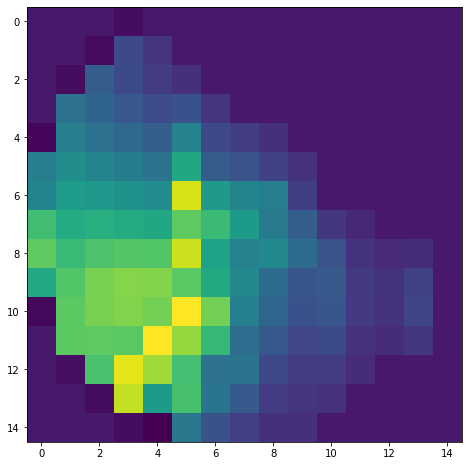

In [10]:
plt.imshow(activations[7])

In [11]:
reload(feat)
reload(sep)

<module 'xrdc.source_separation' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/source_separation.py'>

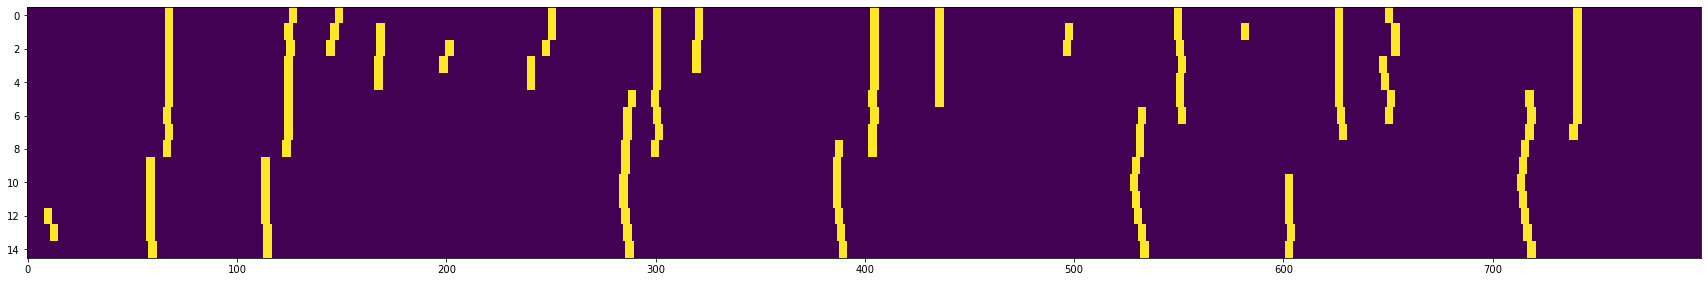

In [62]:
a,b = 3, 5
slice_peaks = feat.color_peaks_2d(fsub_stop_2d[1][5, :], patterns[5], fwhm_max = 20, area_min = 0, imin = 0,
                                 peakwidth = 2)
plt.imshow(slice_peaks, aspect=8, interpolation = 'none')

In [28]:
fsub_stop_2d[1][5, 3:5][1][0]

{'curve 0': {'FWHM': 6.115621155376653,
  'area': 255.61745757308748,
  'area_err': 1.3532148487807464e-06,
  'x0': 67.76790643950413},
 'curve 1': {'FWHM': 8.603445722883805,
  'area': -169.78699777238432,
  'area_err': 1.1241508681096698e-07,
  'x0': 60.8170955669961}}

In [58]:
reload(feat)

<module 'xrdc.featurization' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/featurization.py'>

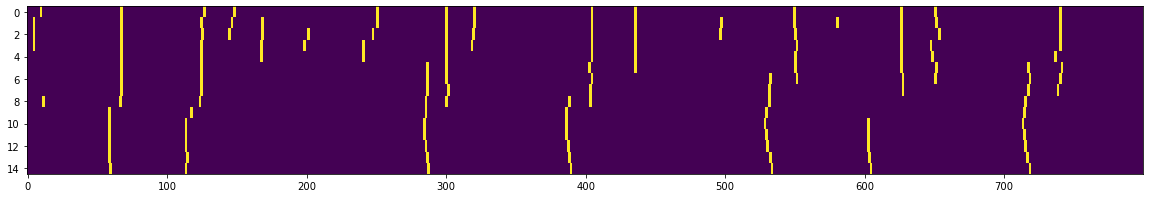

In [442]:
slice_peaks = feat.color_peaks_2d(fsub_stop_2d_2[1][5, :], patterns[5], fwhm_max = 20, area_min = 0, imin = 0,
                                 peakwidth = 1)
plt.imshow(slice_peaks, aspect=8, interpolation = 'none')

In [40]:
# def color_peaks_3d(patterns, peakparams, mask_zero = True, **kwargs):
#     """
#     Given peak fit parameters, return an array of the same shape as patterns with peak regions
#     set to 1.
#     """
#     res = np.array([feat.color_peaks_2d(params_slice, patterns_slice)
#                      for patterns_slice, params_slice in zip(patterns, peakparams)])
#     if mask_zero:
#         mask = (patterns.sum(axis = len(patterns.shape) - 1)) != 0
#         res *= mask[..., None]
#     return res

In [17]:
reload(feat)

<module 'xrdc.featurization' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/featurization.py'>

In [47]:
mask = (patterns.sum(axis = len(patterns.shape) - 1)) != 0
peakmask3d = feat.color_peaks_3d(fsub_stop_2d[1], fast_q)

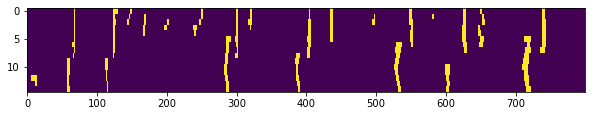

In [52]:
plt.imshow(peak_slices[5], aspect=8, interpolation = 'none')

In [85]:
reload(feat)

<module 'xrdc.featurization' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/featurization.py'>

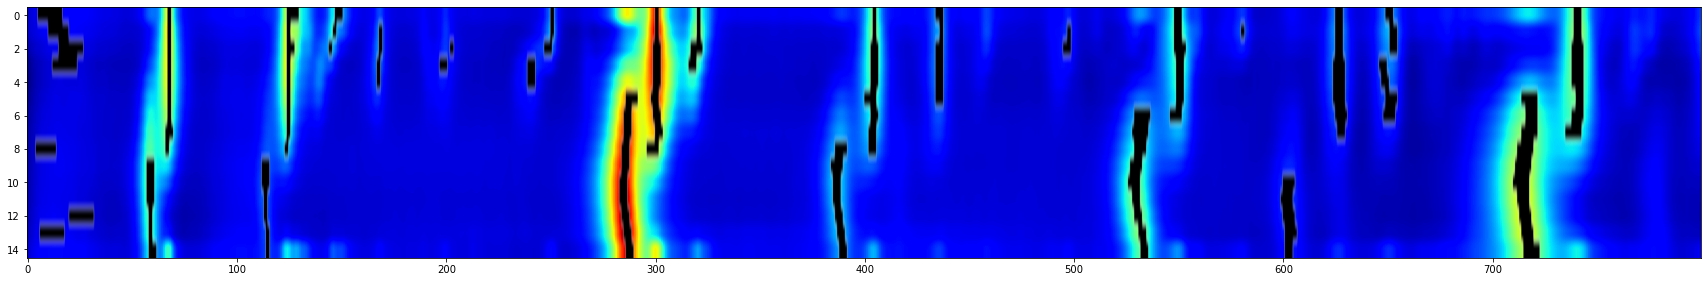

In [41]:
peak_slices = [feat.color_peaks_2d(fsub_stop_2d[1][i, :], patterns[i], fwhm_max = 80, imin = 0,
                                  peakwidth = 'auto')
              for i in range(patterns.shape[0])]

plt.rcParams["figure.figsize"]=(30, 30)
overlay_mask(fast_q[5], peak_slices[5], aspect = 8)

In [48]:
peak_slices[5].mean()

0.05683333333333333

In [74]:
def plot_slices(callback, *args, N = 15, **kwargs):
    a, b = N, 1
    for i in range(N):
        plt.subplot(a, b, i + 1)
        plt.title('slice number {}'.format(i + 1), loc = 'right')
        callback(*(arg[i] for arg in args), **kwargs)
#        plt.imshow(np.log(1 + arr3d[:, i]), cmap = 'jet', interpolation = 'none')

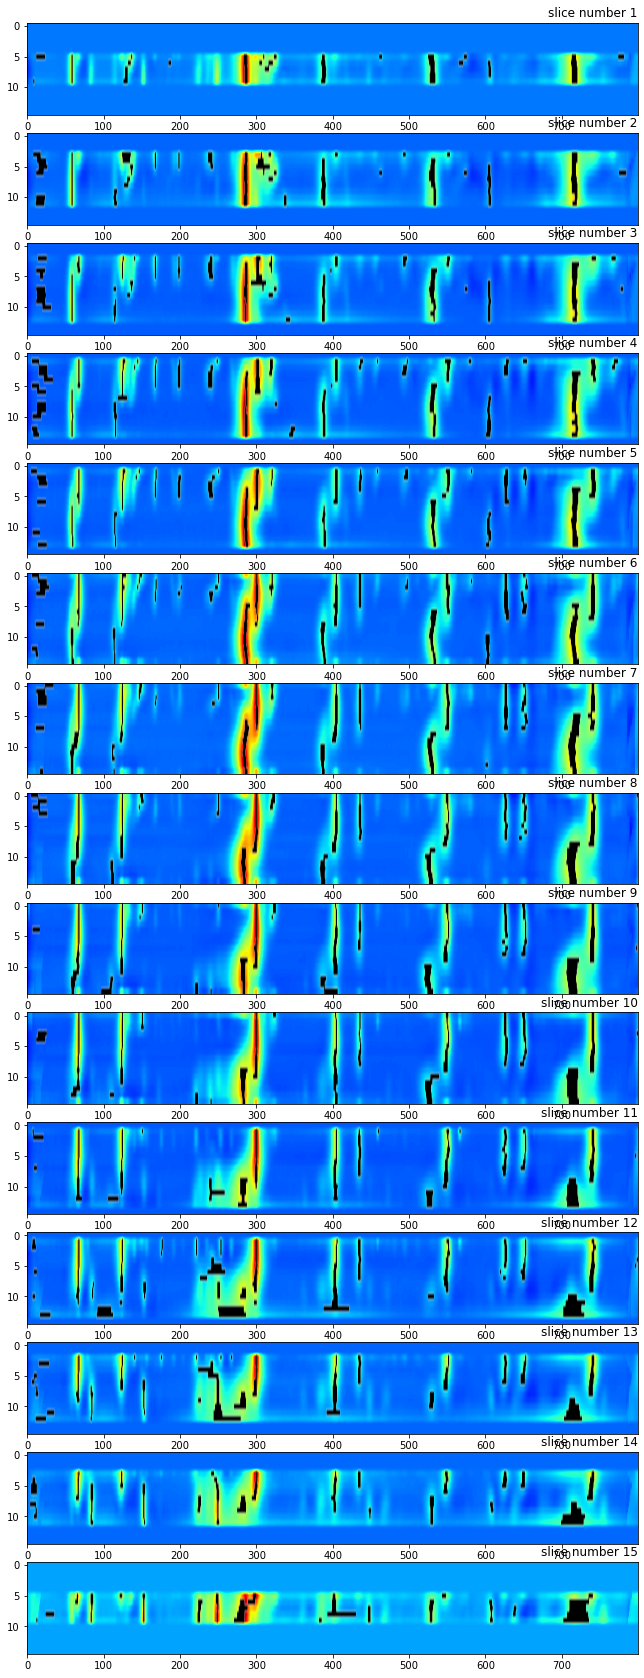

In [107]:
plot_slices(overlay_mask, fast_q * mask[..., None], peak_slices, aspect = 8, vmin = -1)#, vmax = np.log10(1 + fast_q.max()))

### TODO ask why number of peaks found depends on the intensity scale

In [11]:
patterns_pp = fast_q

In [126]:
reload(vis)

<module 'xrdc.visualization' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/visualization.py'>

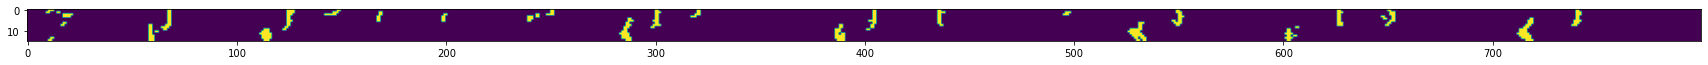

In [35]:
plt.imshow(labeled[5, :, :].astype(bool).astype(int))

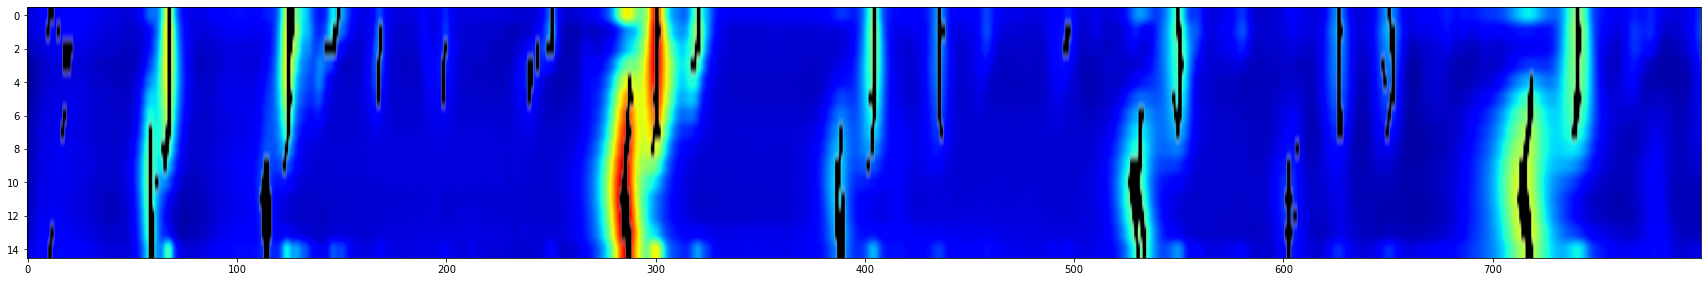

In [63]:
overlay_mask(fast_q[5, :, :], labeled[5, :, :].astype(bool).astype(float), aspect = 8)

In [14]:
plot, volume1 = vis.heatmap3d(fast_q, interpolation = False);

Output()

In [15]:
volume1.volume = volume.volume

NameError: name 'volume' is not defined

In [18]:
# # create opacity func
# opacity_func = np.zeros((256, 2), dtype=np.float32)
# opacity_func[:, 0] = tf.alpha.x /  max(tf.alpha.x) # rescale back between 0.0 and 1.0
# opacity_func[:, 1] = np.linspace(0, 1, 256)
vfeats = (mask[..., None] * rmap(labeled))
vals = np.unique(vfeats.ravel())
vals.sort()
opacity_func = np.ones((len(vals), 2), dtype = np.float32)
opacity_func[:, 0] = vals
color_range = (np.min(vfeats), np.max(vfeats))

import k3d
plot, volume = vis.heatmap3d(vfeats, interpolation = False, opacity_function = opacity_func,
                            color_range = color_range, scale = False, auto_color = False);
#                           color_map=np.array(k3d.basic_color_maps.Jet, dtype=np.float32)

volume.volume = vfeats


/home/ollie/anaconda3/lib/python3.8/site-packages/k3d/objects.py:1175: UserWarning: wrong dtype: float64 ([<class 'numpy.float16'>, <class 'numpy.float32'>] required)
  warnings.warn("wrong dtype: %s (%s required)" % (actual, required))


Output()

In [99]:
reload(vis)

<module 'xrdc.visualization' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/visualization.py'>

In [98]:
volume.volume = np.log(1 + 10 * fast_q / fast_q.max())

In [167]:
volume.volume = peakmask3d

In [363]:
%pdb

Automatic pdb calling has been turned ON


In [410]:
reload(feat)

<module 'xrdc.featurization' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/featurization.py'>

In [ ]:
mark

In [ ]:
fast

(0.4323492203716807, 0.3893842895674234)

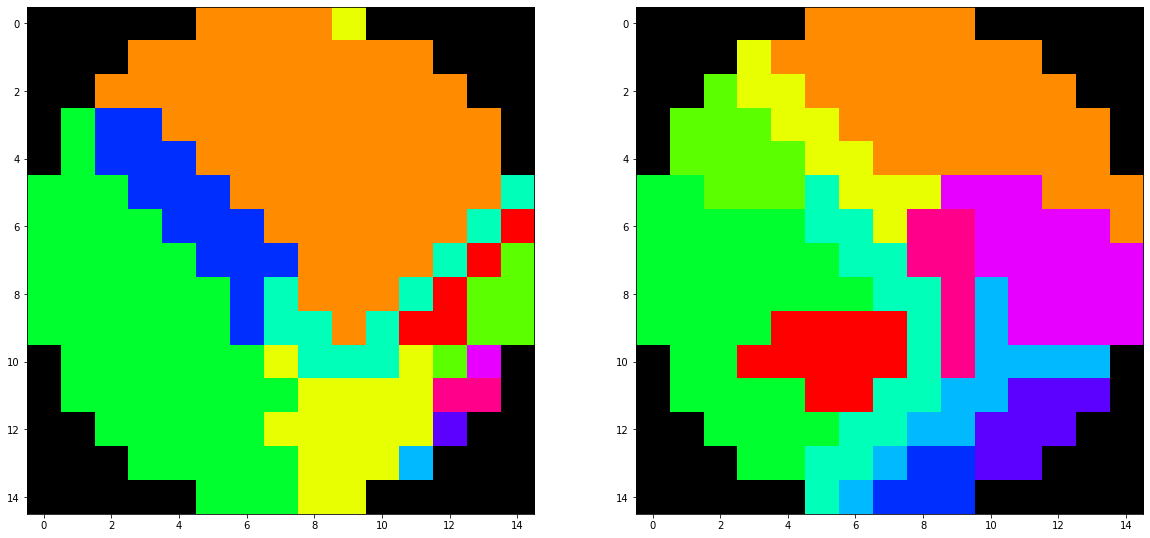

In [433]:
if debug:
    clust, sorter, clust_cms = feat.do_clust(patterns.T, nclust, ctype = 'agglom', linkage = 'average',
                                        affinity = 'cosine')
else:
    clust, sorter, clust_cms = feat.do_clust(fast_q_flat, activations[:, mask], nclust, ctype = 'agglom', linkage='average',
                                        affinity='cosine')


plt.subplot(1, 2, 1)
plot_clusters_grid(coords, clust, nclust)


plt.subplot(1, 2, 2)
plot_clusters_grid(get_coords(dgrid), y, 11)

# ax = fig.add_subplot(1,end-start,i-start+1)
# ax.imshow(cg)
# ax.invert_yaxis()
# ax.title.set_text(i)
# ax.axis("off")
# fig.show()

from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import adjusted_rand_score as rand

ami(y, clust), rand(y, clust)

In [11]:
axis = 3
activations = np.log(1 + (feature_masks * patterns).sum(axis = axis))
#activations = (feature_masks * patterns).sum(axis = axis)
scale = np.mean(activations, axis = (1, 2))
# activations_n1 = activations / scale[:, None, None]
activations_n1 = feat.norm(activations)

mask = (patterns.sum(axis = 2) != 0)
patterns = patterns[mask]


NameError: name 'feature_masks' is not defined

> <ipython-input-11-5e5ad98528b5>(2)<module>()
      1 axis = 3
----> 2 activations = np.log(1 + (feature_masks * patterns).sum(axis = axis))
      3 #activations = (feature_masks * patterns).sum(axis = axis)
      4 scale = np.mean(activations, axis = (1, 2))
      5 # activations_n1 = activations / scale[:, None, None]

ipdb> c


NameError: name 'dgrid' is not defined

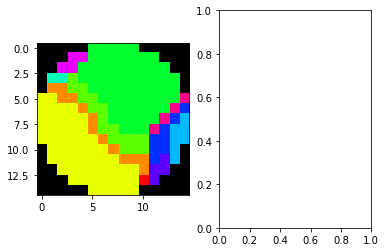

In [26]:
if debug:
    clust, sorter, clust_cms = feat.do_clust(patterns.T, nclust, ctype = 'agglom', linkage = 'average',
                                        affinity = 'cosine')
else:
    clust, sorter, clust_cms = feat.do_clust(patterns, activations[:, mask], nclust, ctype = 'agglom', linkage='average',
                                        affinity='cosine')


plt.subplot(1, 2, 1)
d3d.plot_clusters_grid(d3d.get_coords(d3d.dgrid), clust, nclust)


plt.subplot(1, 2, 2)
d3d.plot_clusters_grid(d3d.get_coords(dgrid), y, 11)

# ax = fig.add_subplot(1,end-start,i-start+1)
# ax.imshow(cg)
# ax.invert_yaxis()
# ax.title.set_text(i)
# ax.axis("off")
# fig.show()

from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import adjusted_rand_score as rand

ami(y, clust), rand(y, clust)

In [29]:
slow_q, fast_q, slow_T, fast_T = sep.separate_signal(patterns, cutoff = .2, threshold = 50)

In [30]:
patterns.shape, m3d_agglom.shape

((177, 400), (15, 15, 400))

In [ ]:
max_ind = argrelextrema(orig, np.greater, axis = axis)
#     max_ind_2 = argrelextrema(orig, np.greater, axis = 0)
#     max_ind = np.hstack((max_ind[0], max_ind_2[0])), np.hstack((max_ind[1], max_ind_2[1]))

edges = np.zeros_like(orig)
edges[max_ind] = 1

/Users/ollie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


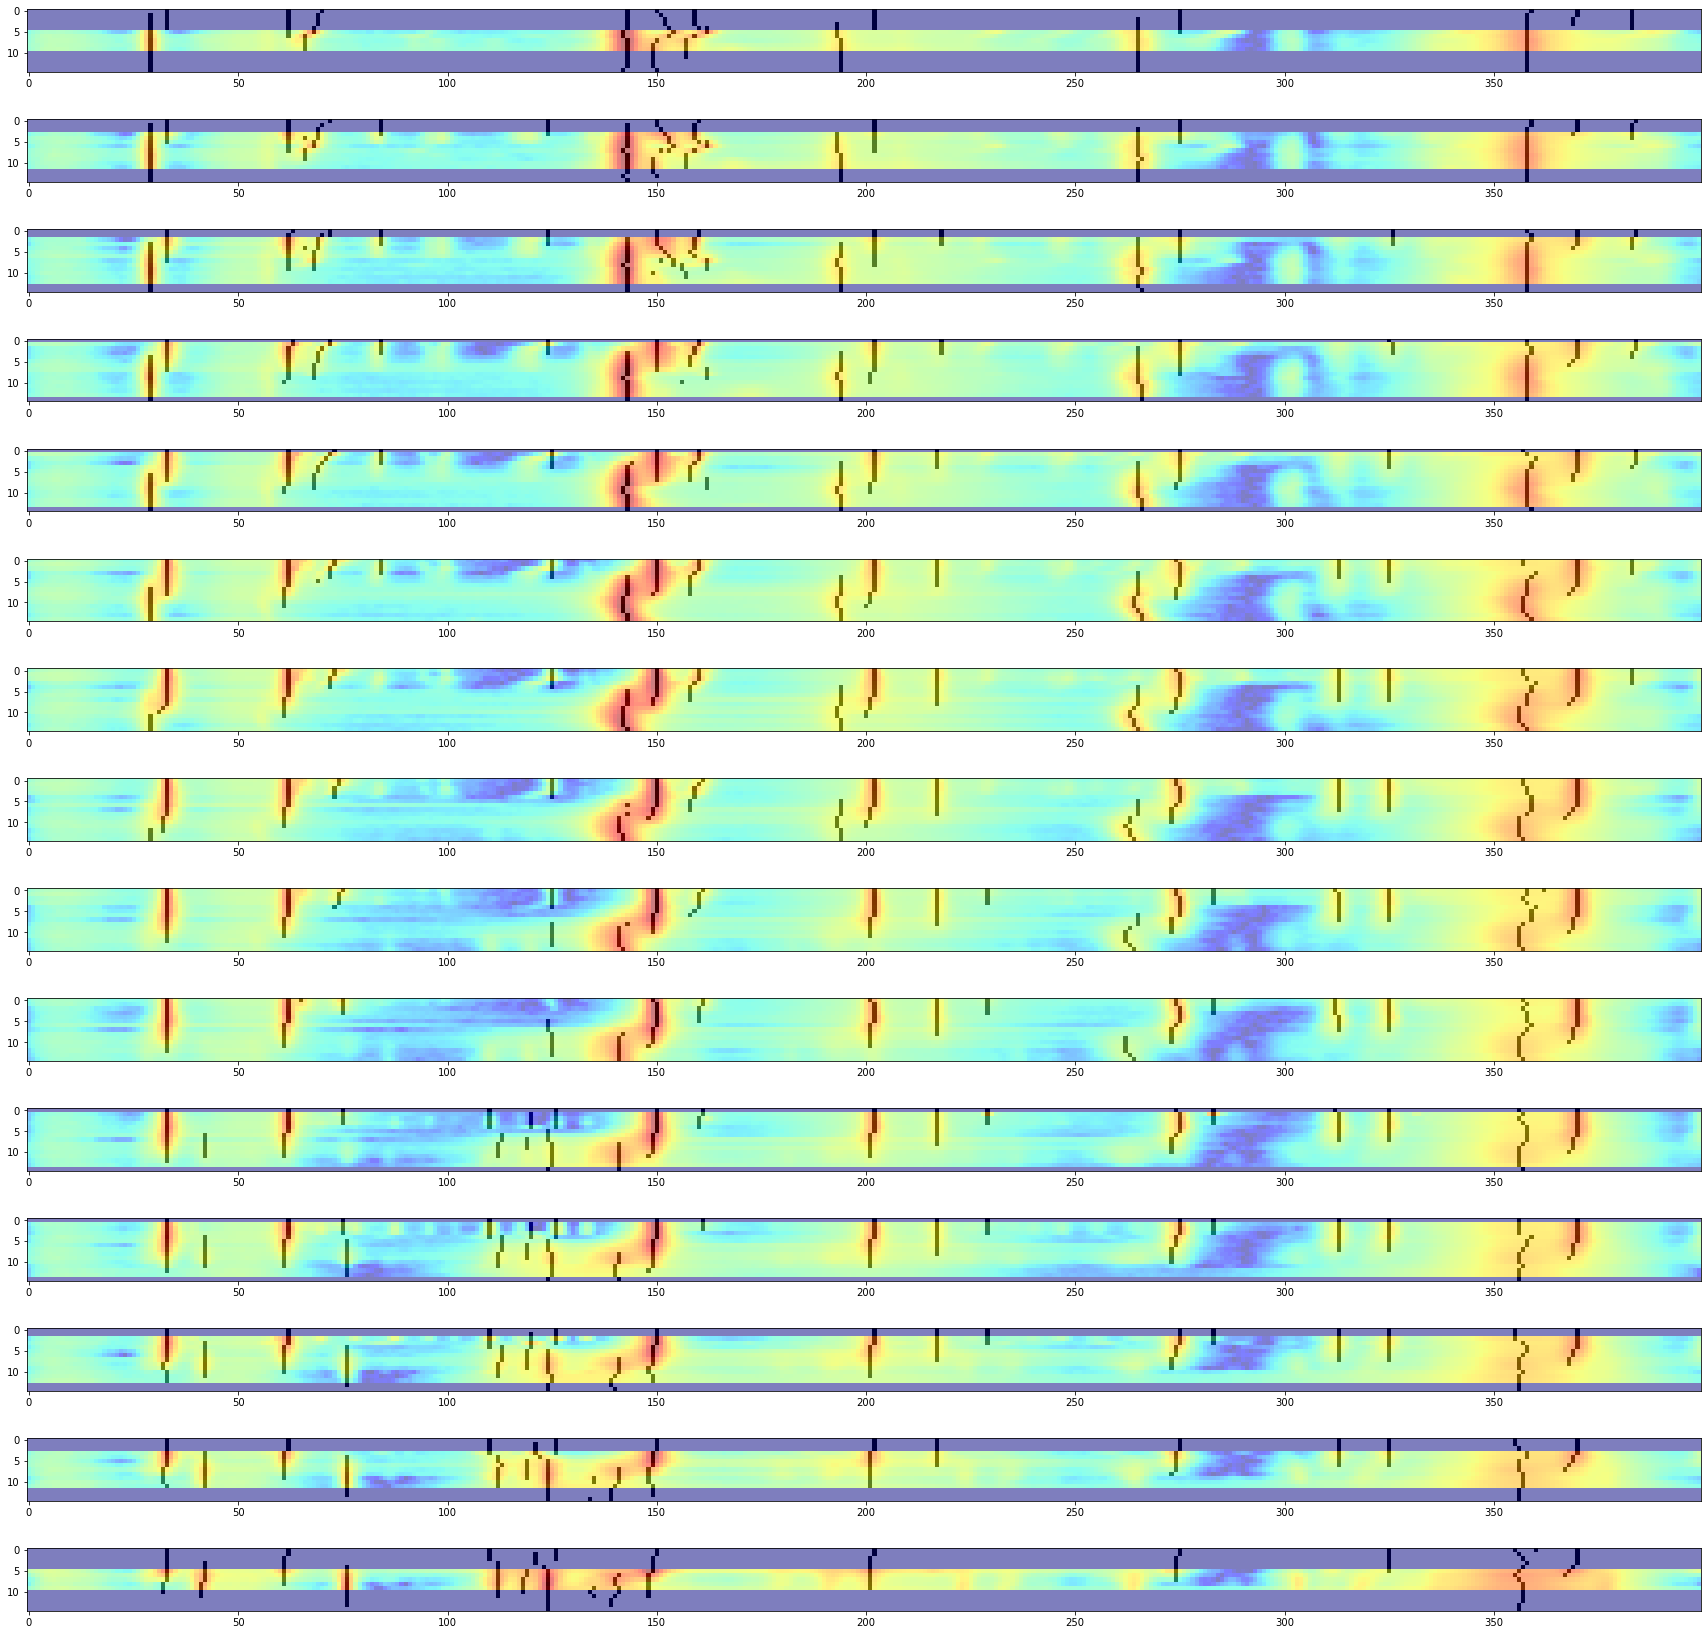

In [467]:
plt.rcParams["figure.figsize"]=(30, 30)

a, b = dim, 1

def plot_cuts(m3d_agglom, axis = 0, cmap = 'jet', **kwargs):
    for i in range(15):
        plt.subplot(a, b, i + 1)
        if axis == 0:
            plt.imshow(np.log(1 + m3d_agglom[i, :]), cmap = cmap, **kwargs)
        if axis == 1:
            plt.imshow(np.log(1 + m3d_agglom[:, i]), cmap = cmap, **kwargs)
plot_cuts(m3d_agglom)
plot_cuts(ridges, alpha = .5, cmap = 'Greys')

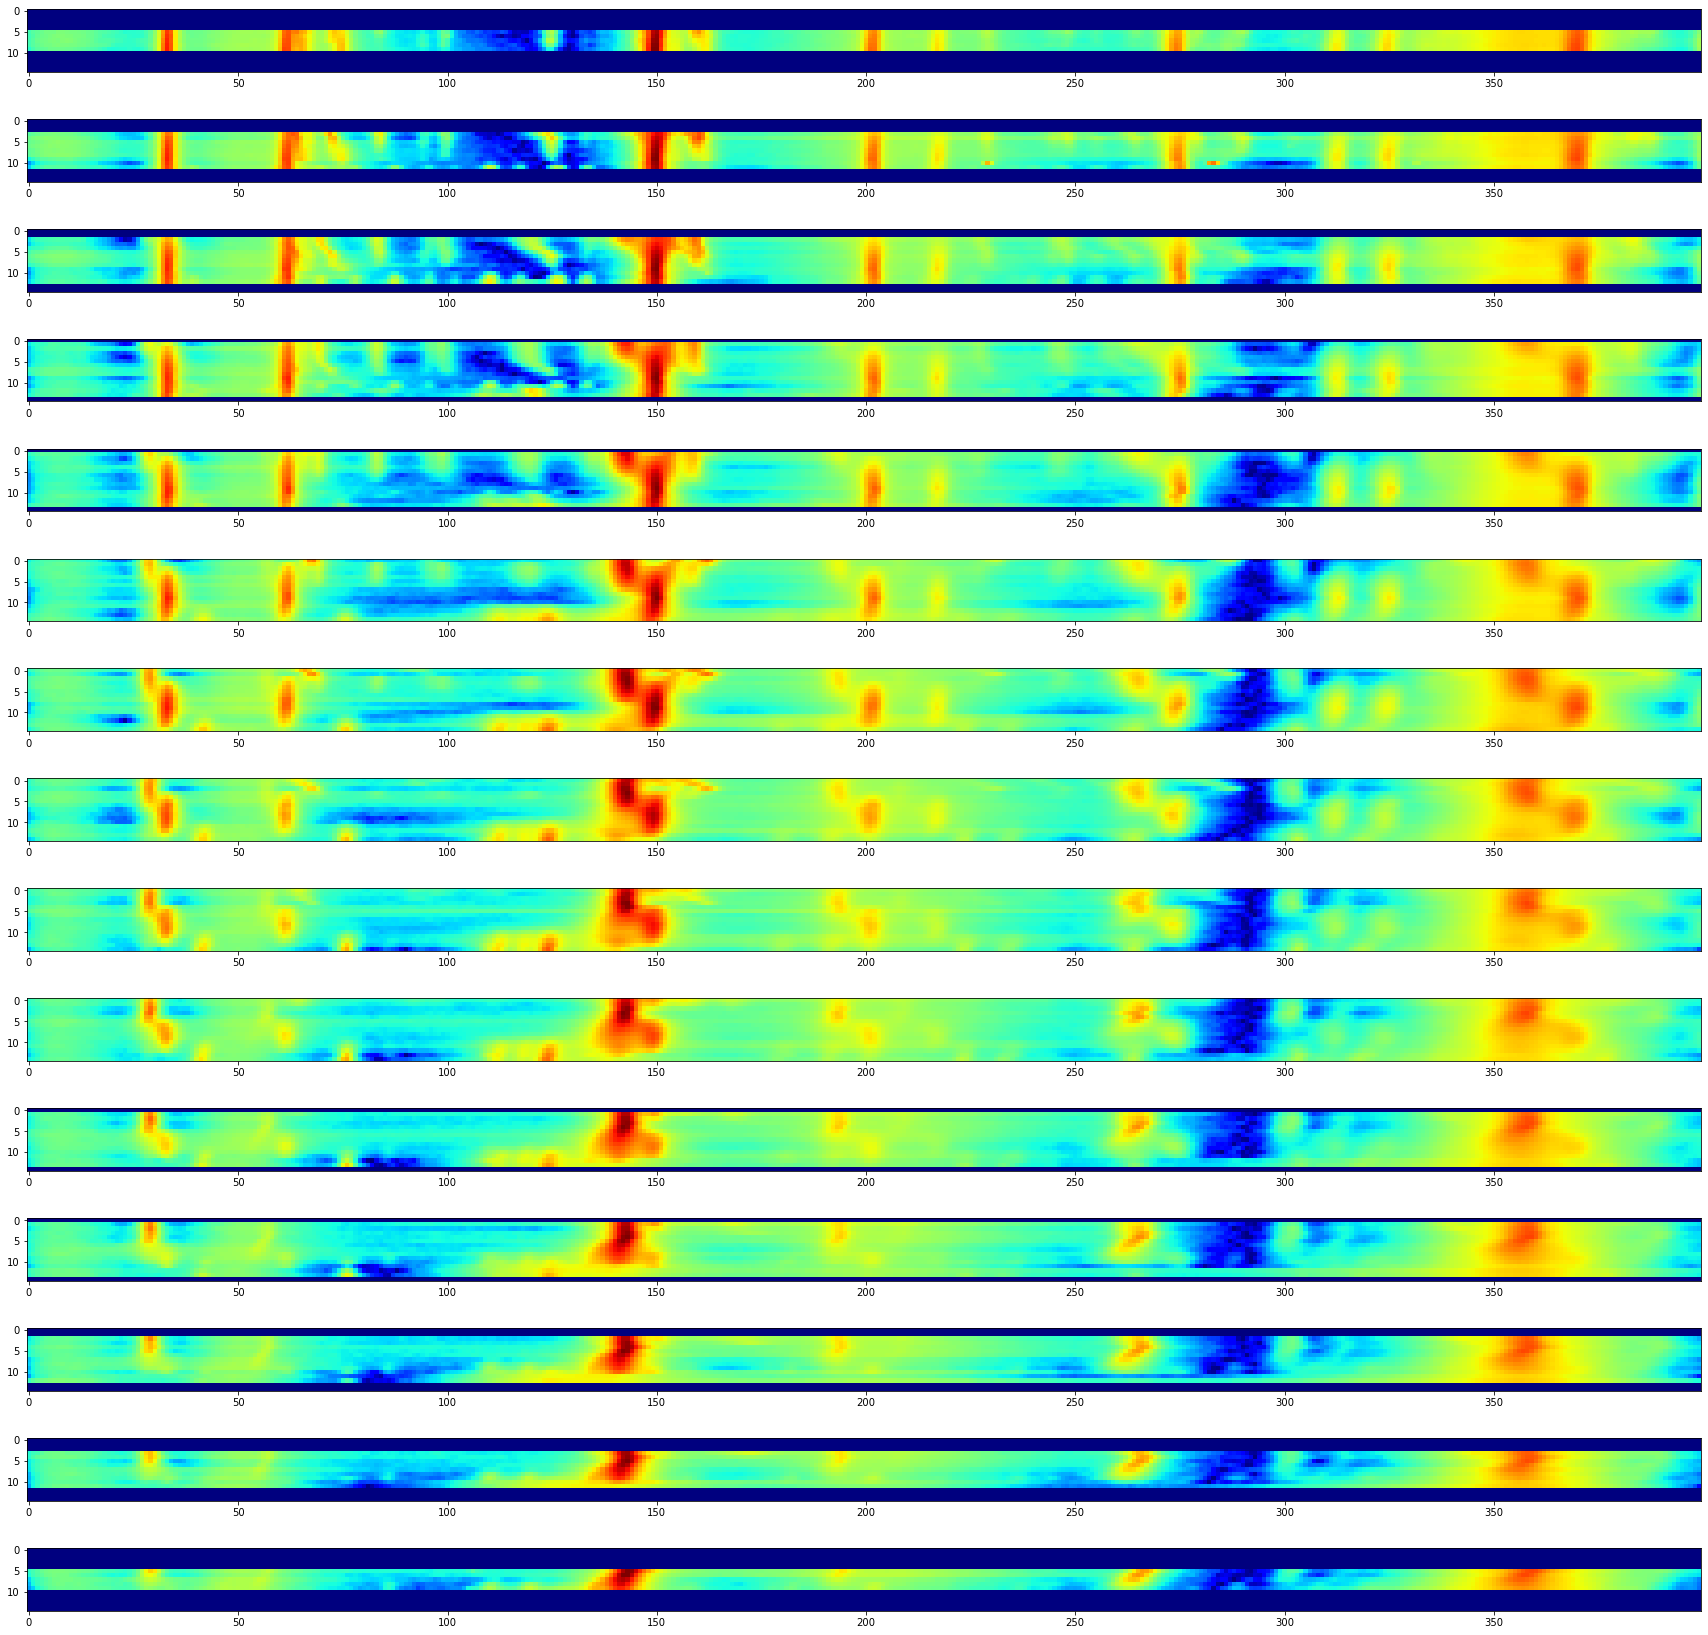

In [470]:
for i in range(15):
    plt.subplot(a, b, i + 1)
    plt.imshow(np.log(1 + m3d_agglom[:, i]), cmap = 'jet', interpolation = 'none')
# plot_cuts(ridges, alpha = .5, cmap = 'Greys')

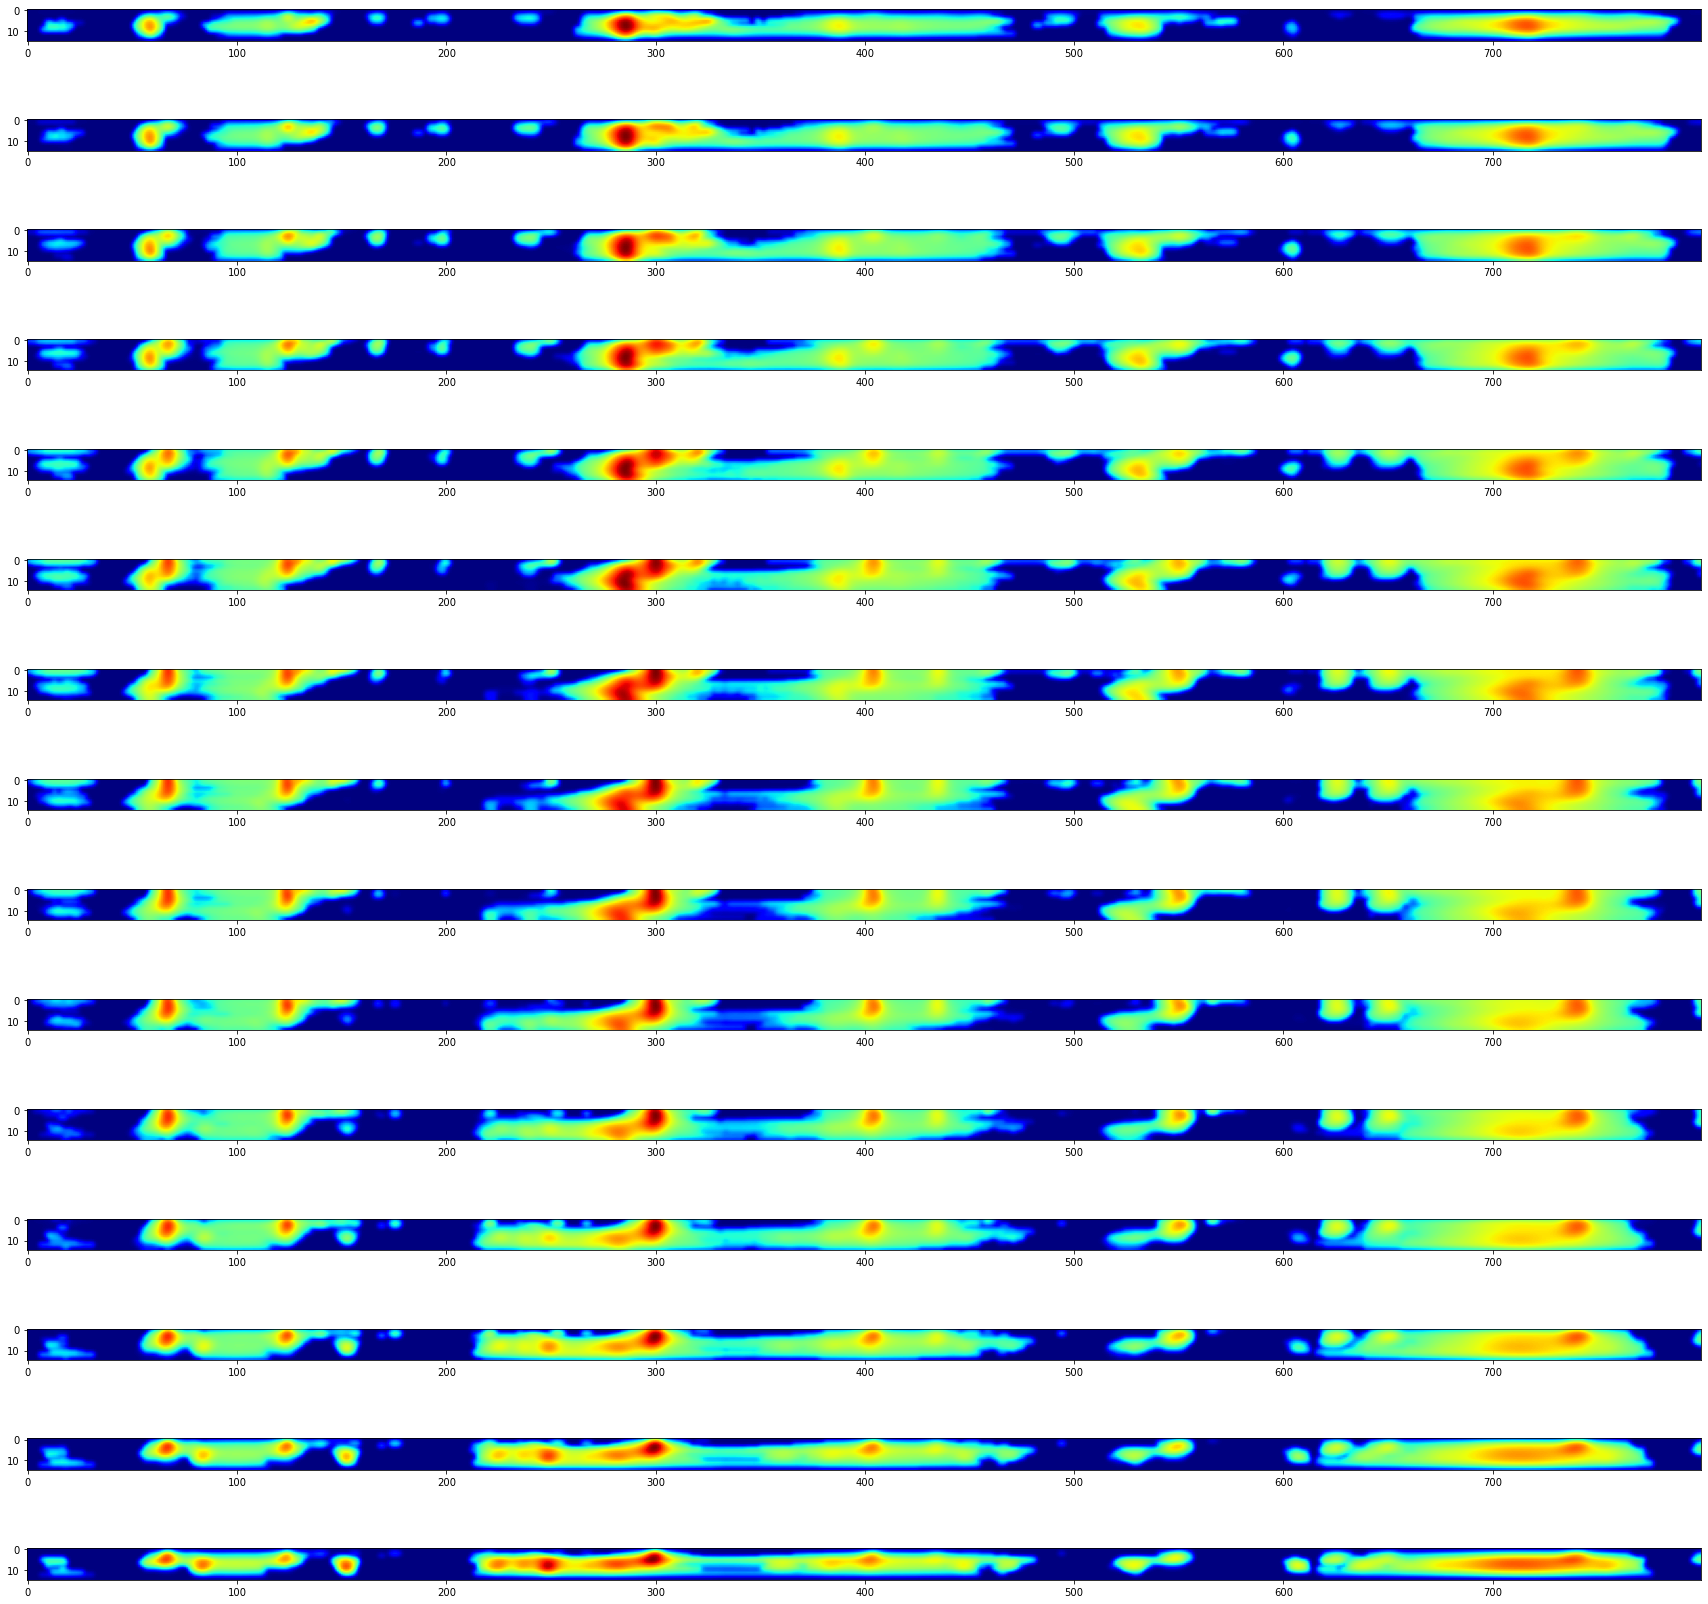

In [114]:
plot_cuts(preprocess(m3d, smooth = 1))

In [131]:
# m3d_agglom = m3d_agglom[:, :14]

In [210]:
m3d_agglom.shape

(15, 15, 400)

In [246]:
ridges.max()

1.0

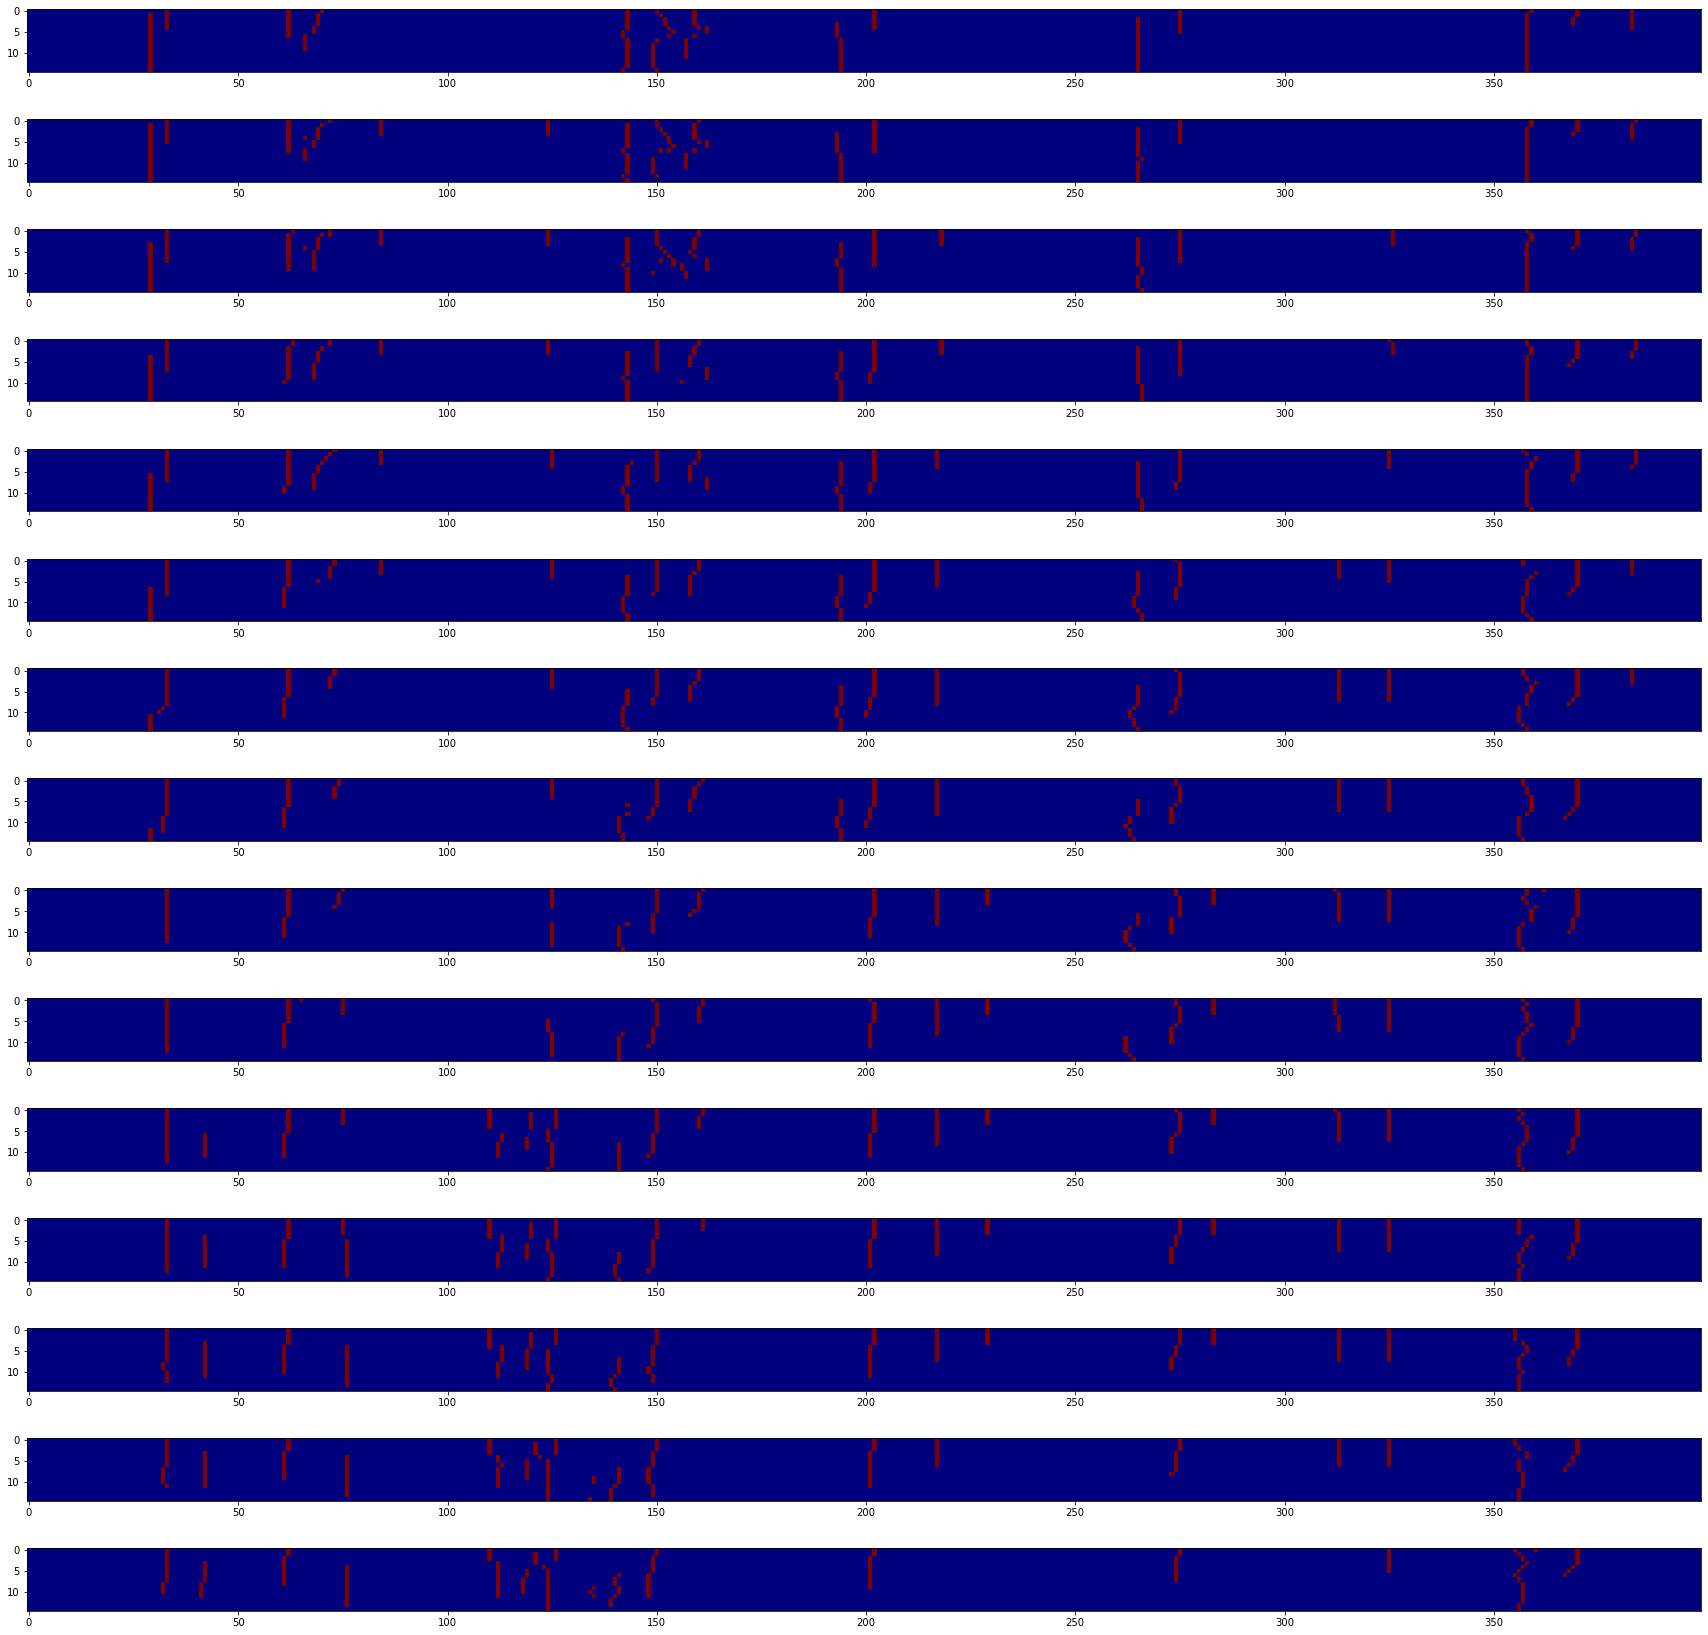

In [616]:
plot_cuts(ridges)

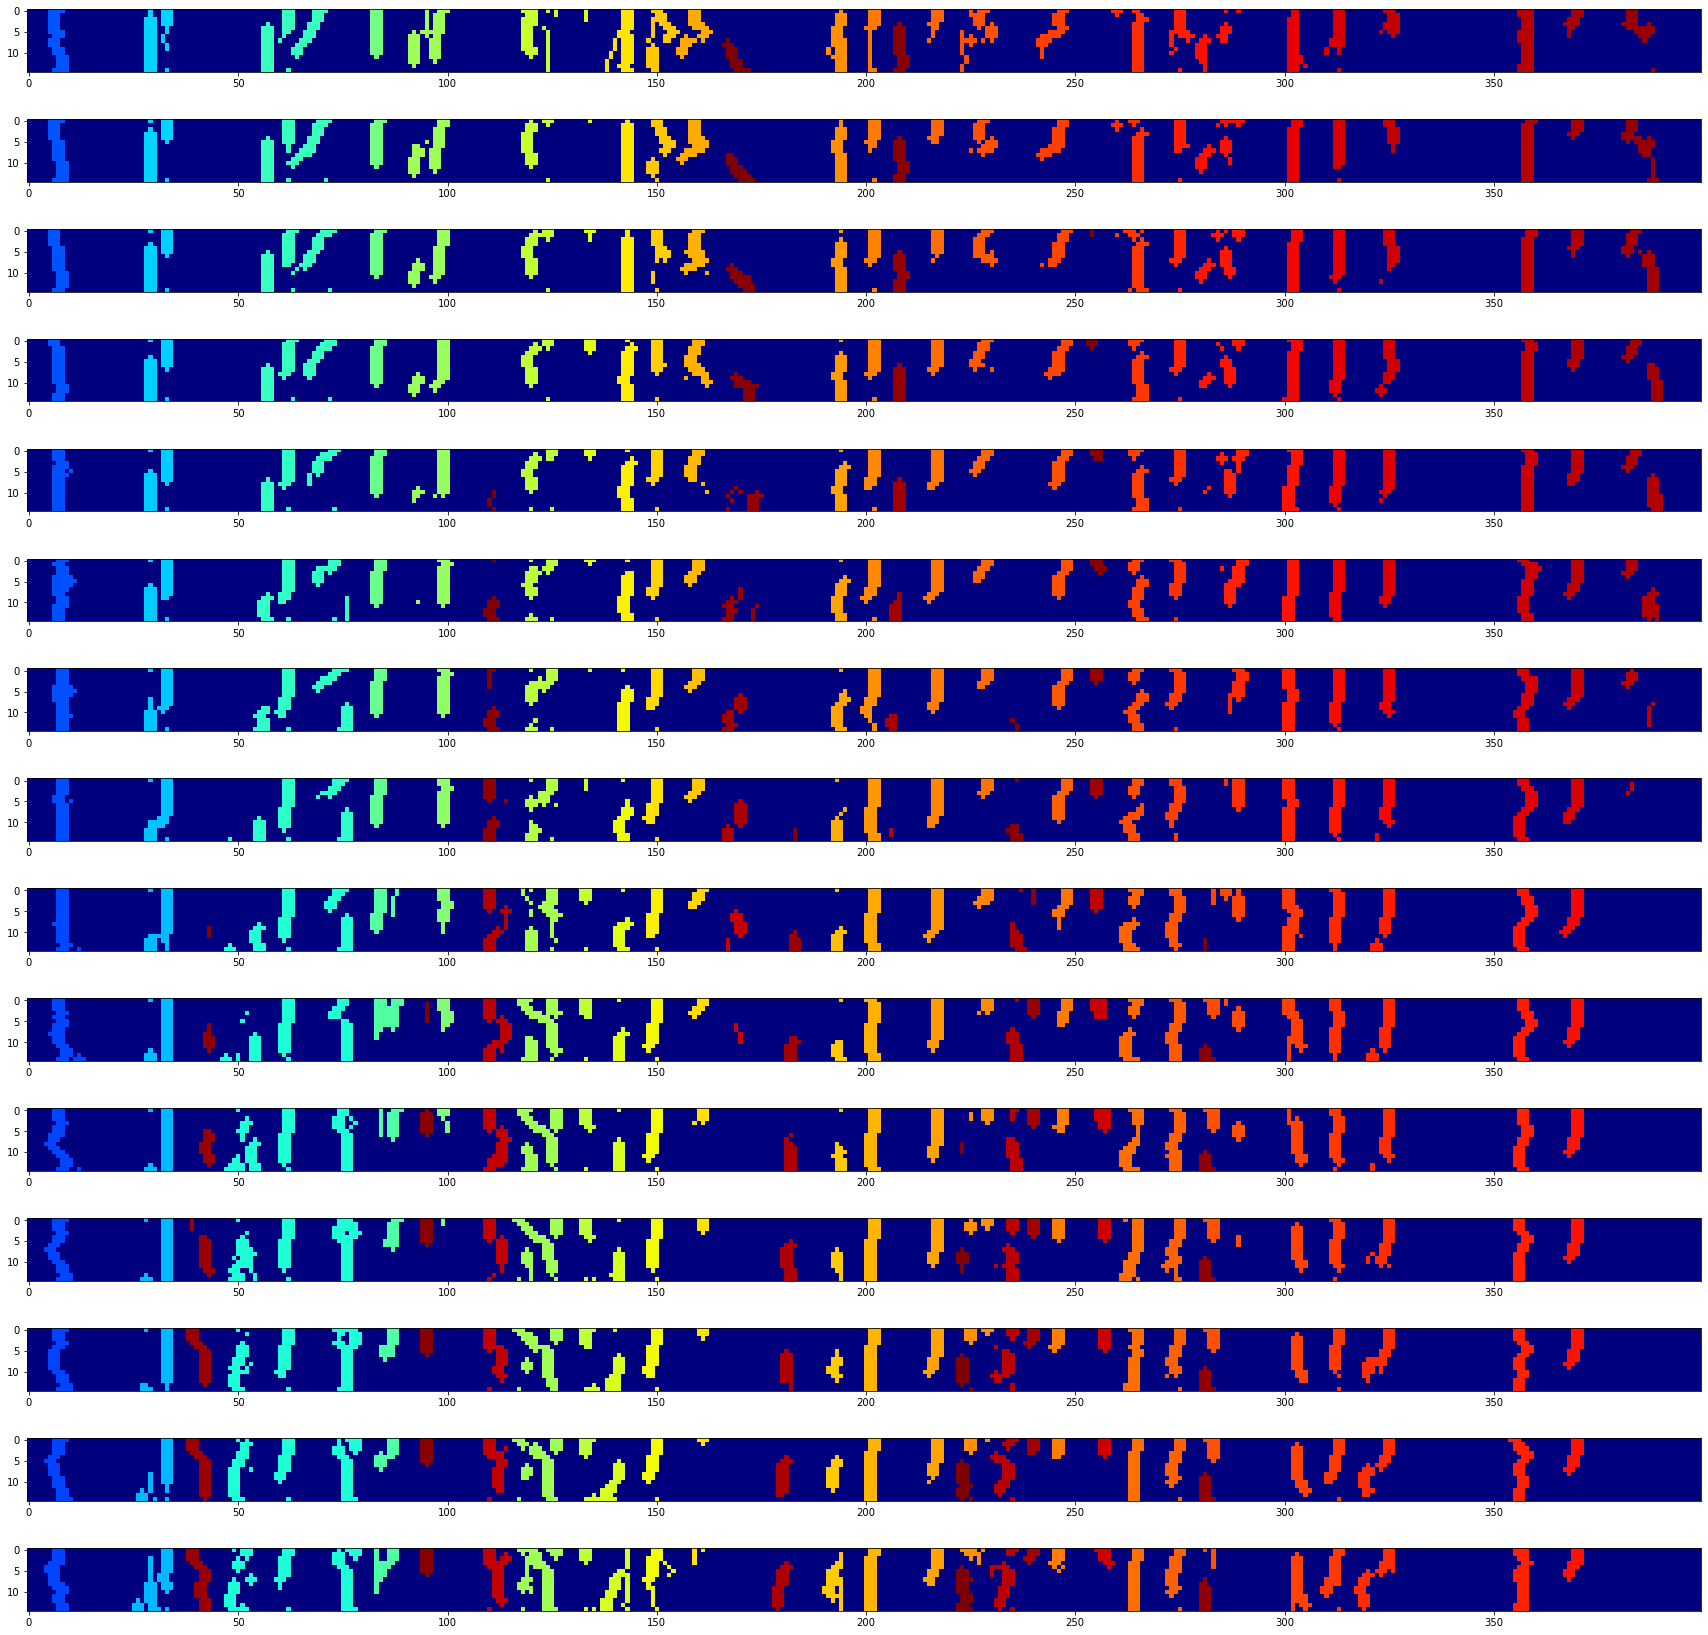

In [655]:
plot_cuts(labeled)

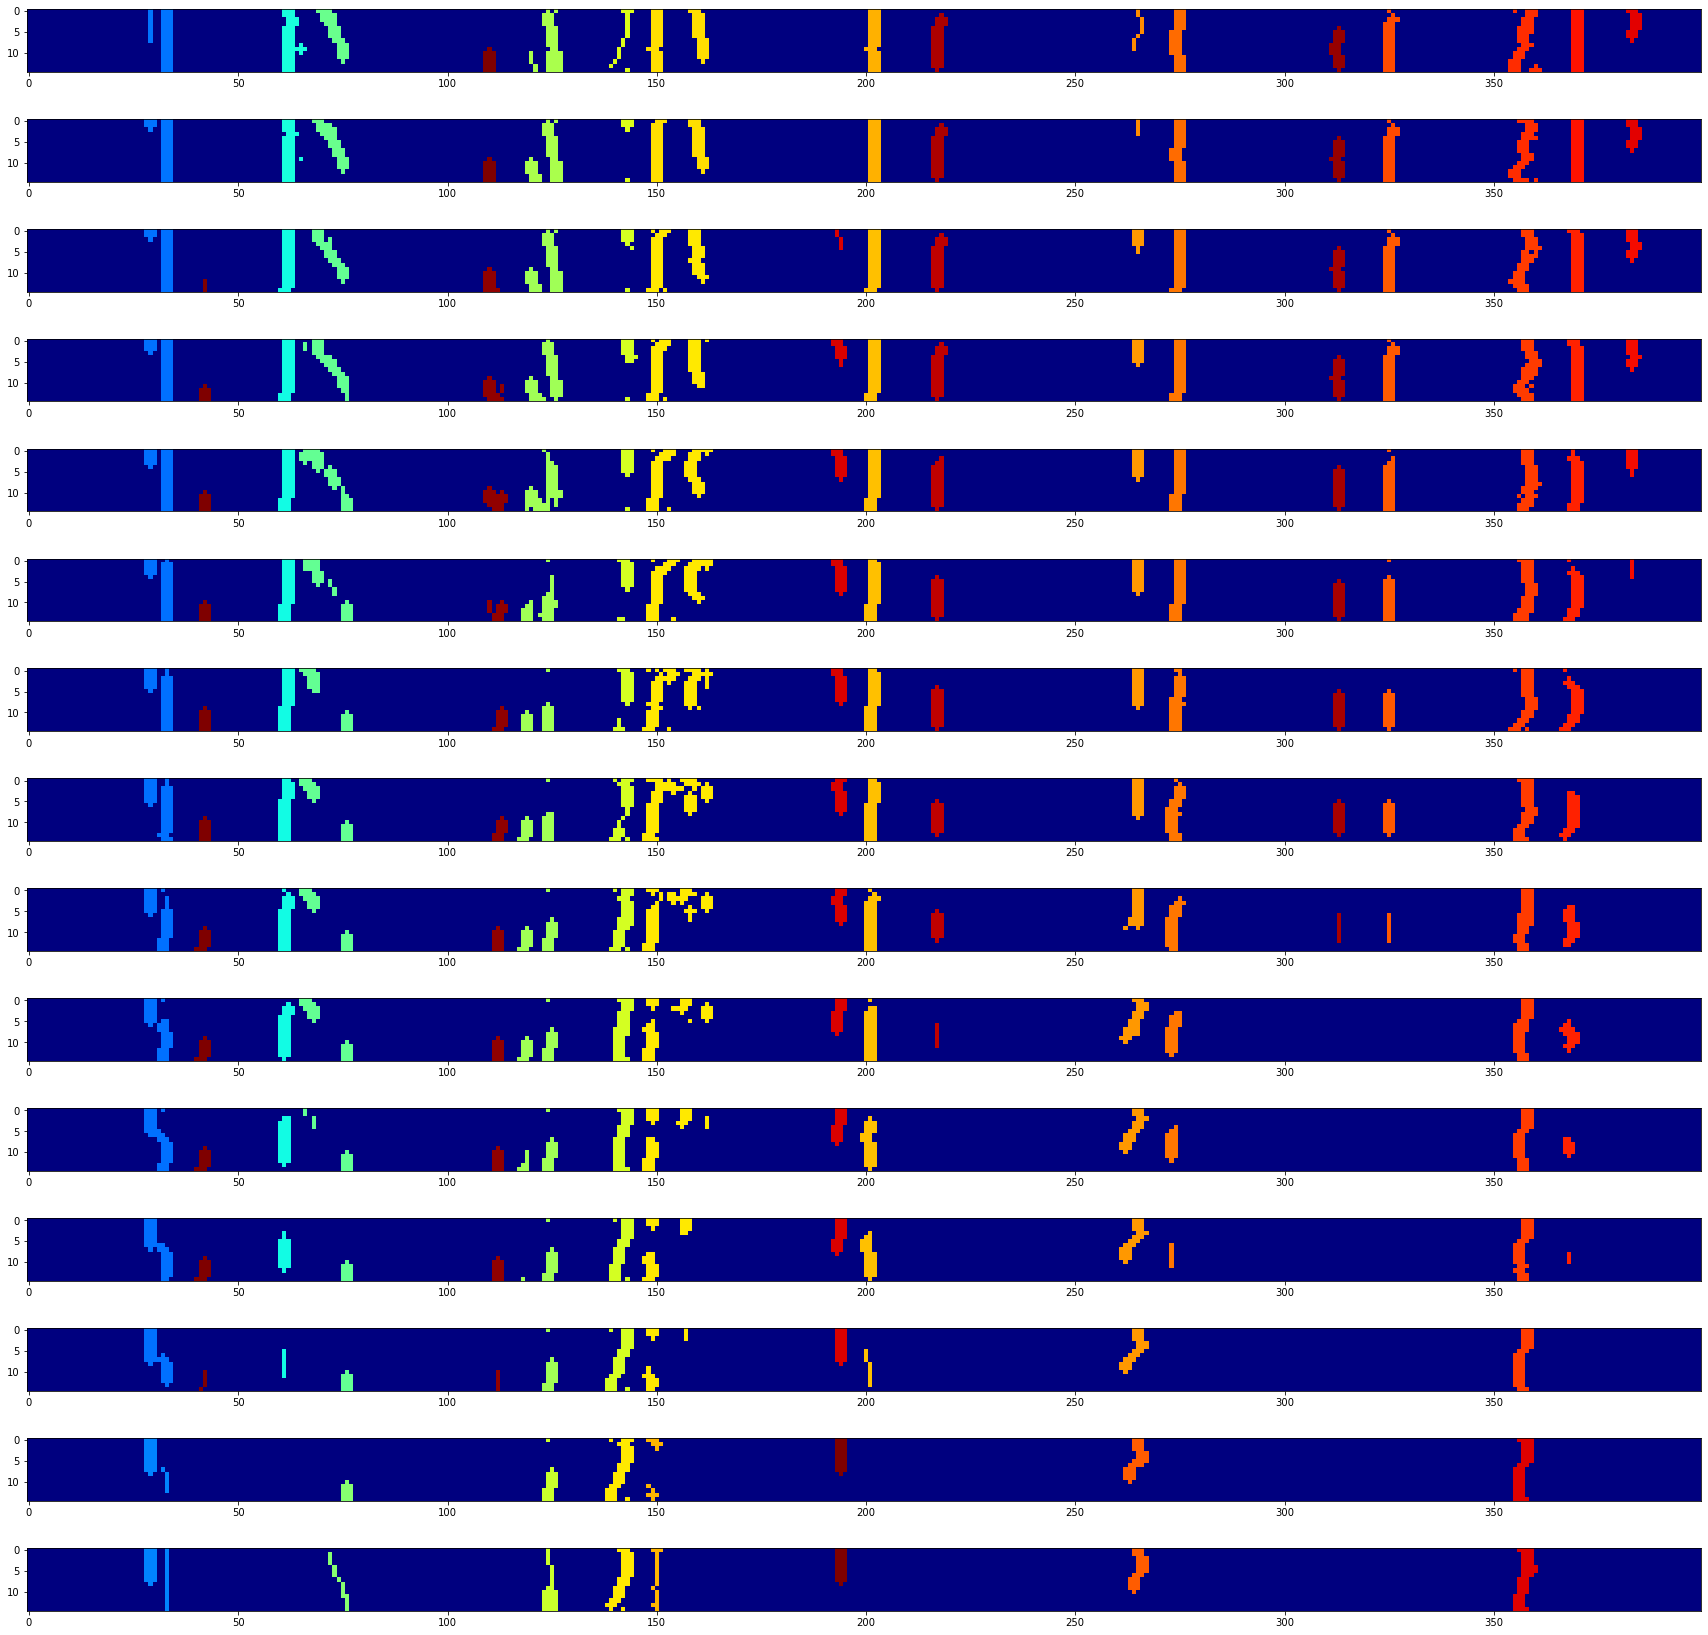

In [618]:
plot_cuts(labeled, axis = 1)

### Test cases for the visualization:

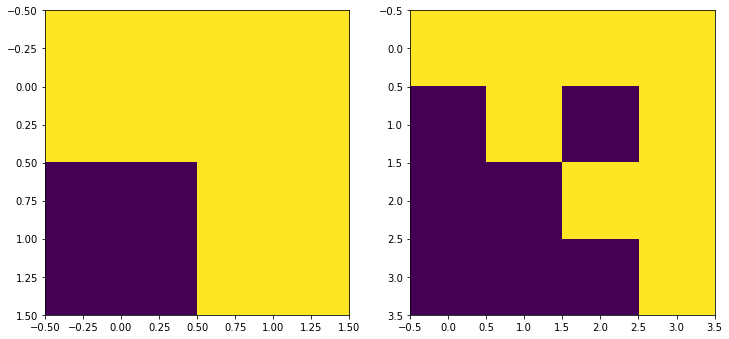

In [1726]:
ta = np.ones((3, 2, 2))

ta[:, 1, 0] = 0

plt.rcParams["figure.figsize"]=(12, 12)
a, b = 1, 2

plt.subplot(a, b, 1)
plt.imshow(ta.sum(axis = 0))

plt.subplot(a, b, 2)
ttmp = np.einsum("kij, klm->ijlm", ta, ta)
plt.imshow((gridstack(ttmp)))

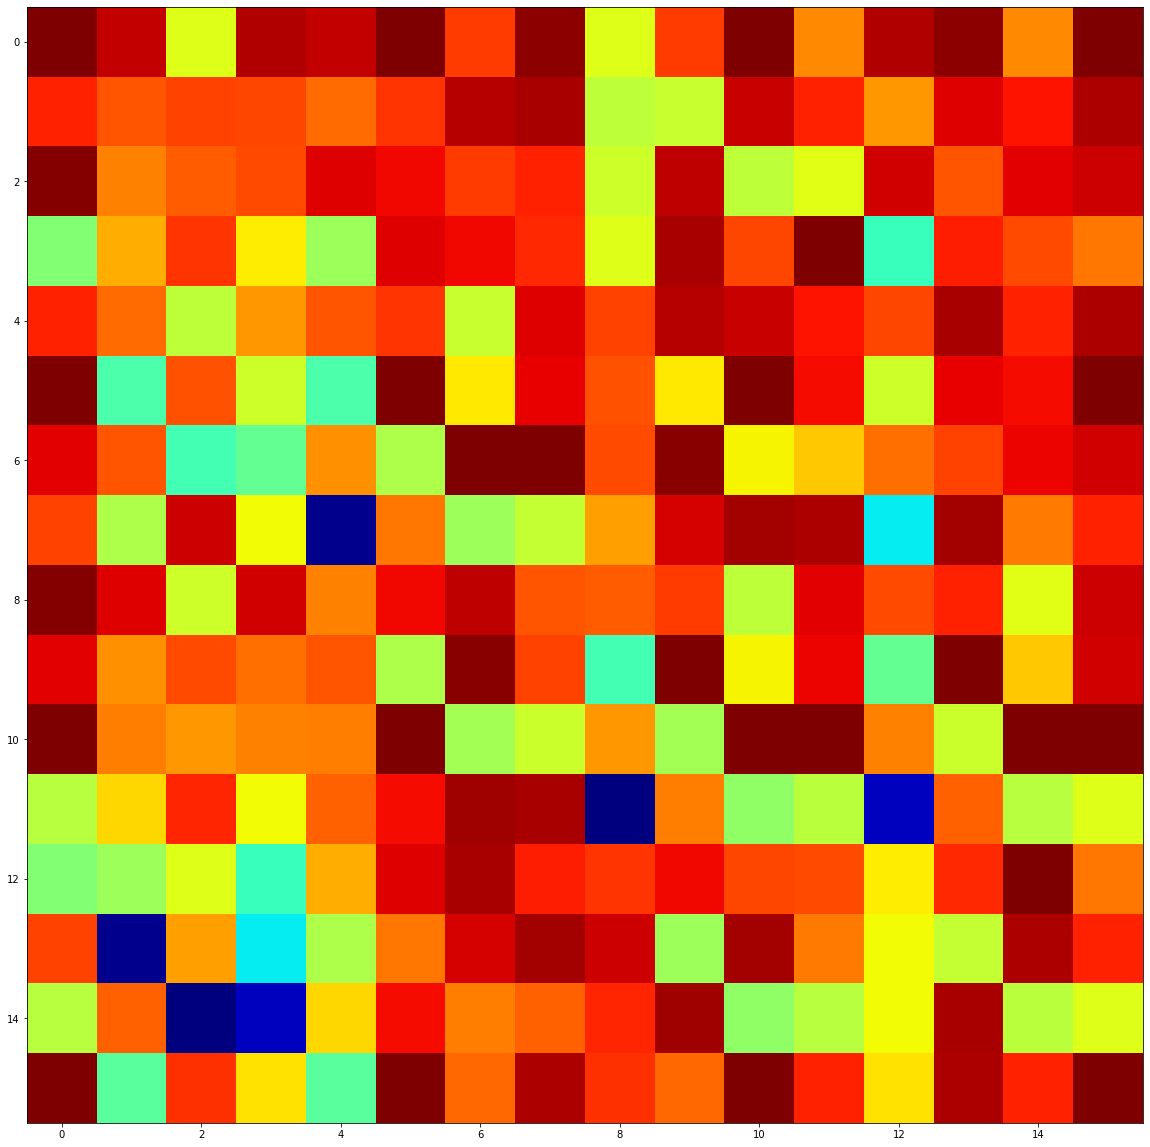

In [1841]:
ta = np.random.rand(3, 4, 4)
ta[0, 3, 0] = 0
#ta[1, 3, 0] = 0
ta[2, 3, 0] = 0
ta[:, 2, 1] *= 10


scale = np.log(np.mean(ta, axis = (1, 2)))

activations_n1 = ta * 2 # / scale[:, None, None]
activations_n1[:, 0, 1] = 2
ttmp = np.einsum("kij, klm->ijlm", activations_n1, activations_n1)

norm = np.linalg.norm(activations_n1, axis = 0)

norm4d = np.einsum("ij, kl->ijkl", norm, norm)

tmp_csim = ttmp / (norm4d + 1e-10)

plt.imshow((gridstack(tmp_csim)), cmap = 'jet')

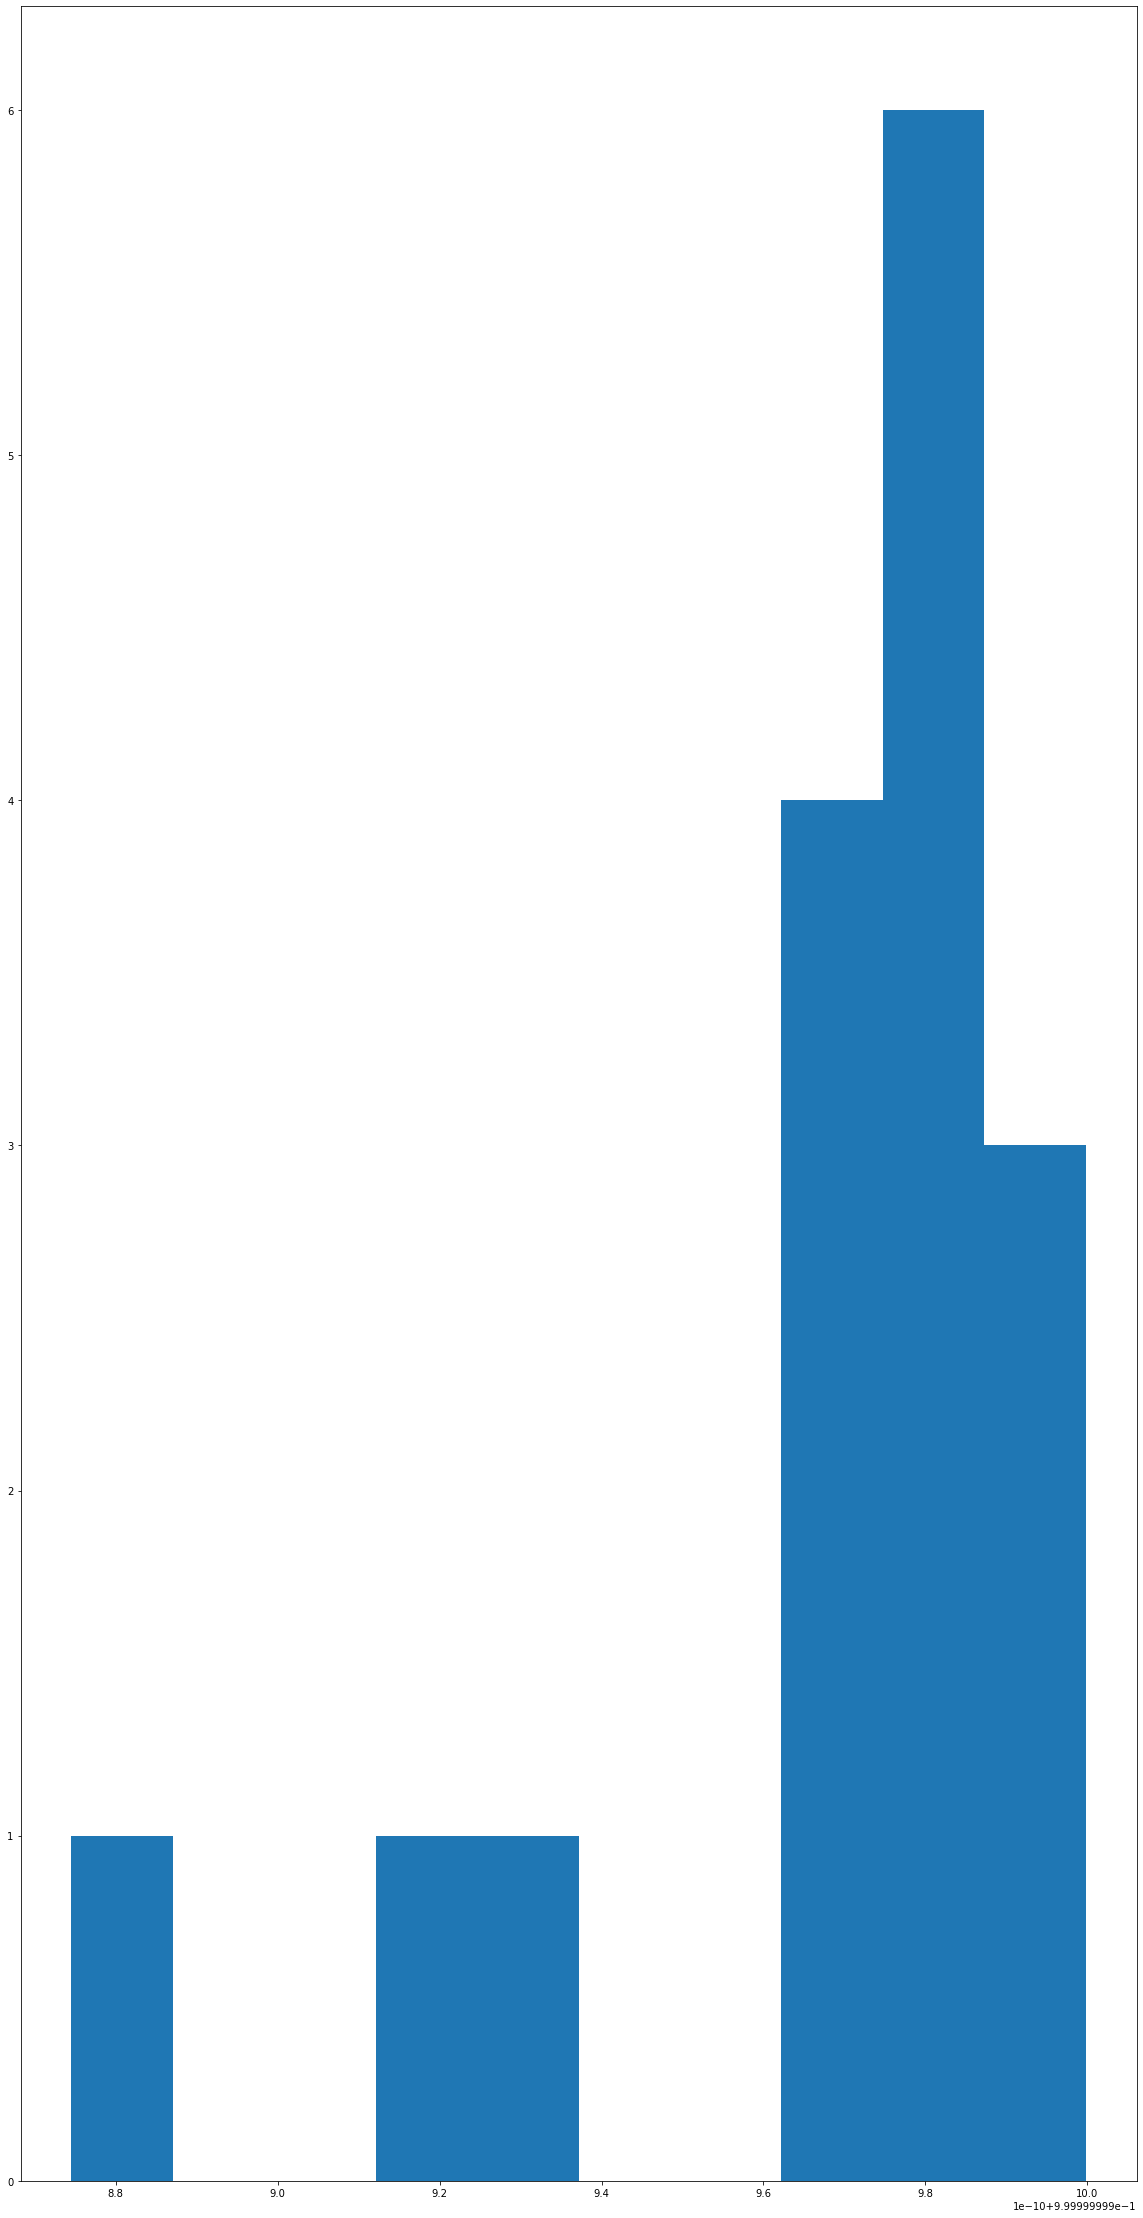

In [1842]:
plt.hist(tmp_csim.max(axis = (0, 1)).ravel(), bins = 10);

In [226]:
%pdb

Automatic pdb calling has been turned ON


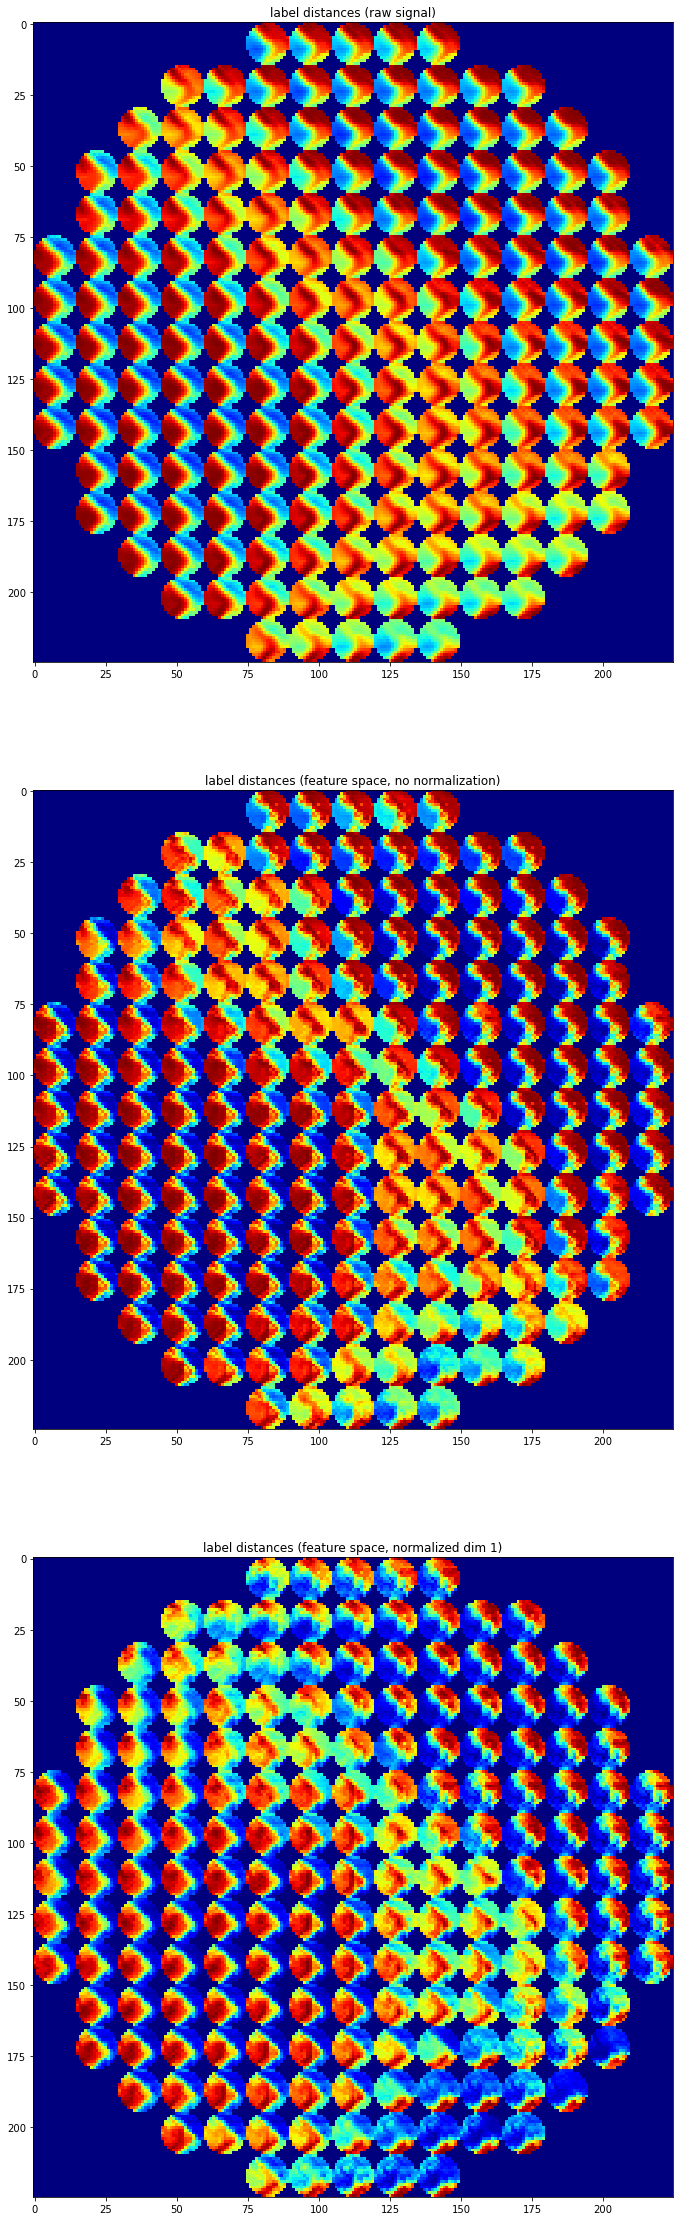

In [22]:
plt.rcParams["figure.figsize"]=(20, 40)

a, b, = 3, 1
similarity_plot_row(csim3d, "label", swap3d(patterns), activations, activations_n1, 
                        activations_n1_log = None, offset = 0, swapper = None,
                   plotter = lambda arr: simple_heatmap(gridstack(arr)))

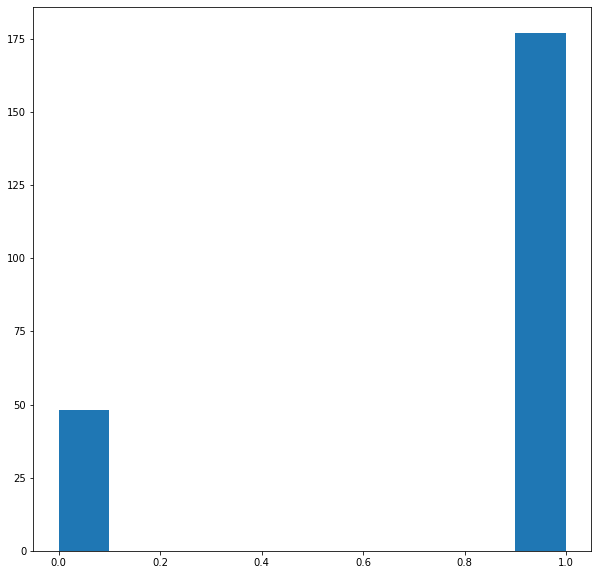

In [1789]:
plt.hist(tmp_csim.max(axis = (0, 1)).ravel());

### Compare to a wrong way of calculating the similarity matrix:

In [1675]:
csim2 = l2_pairs(activations.reshape(16, -1).T).T

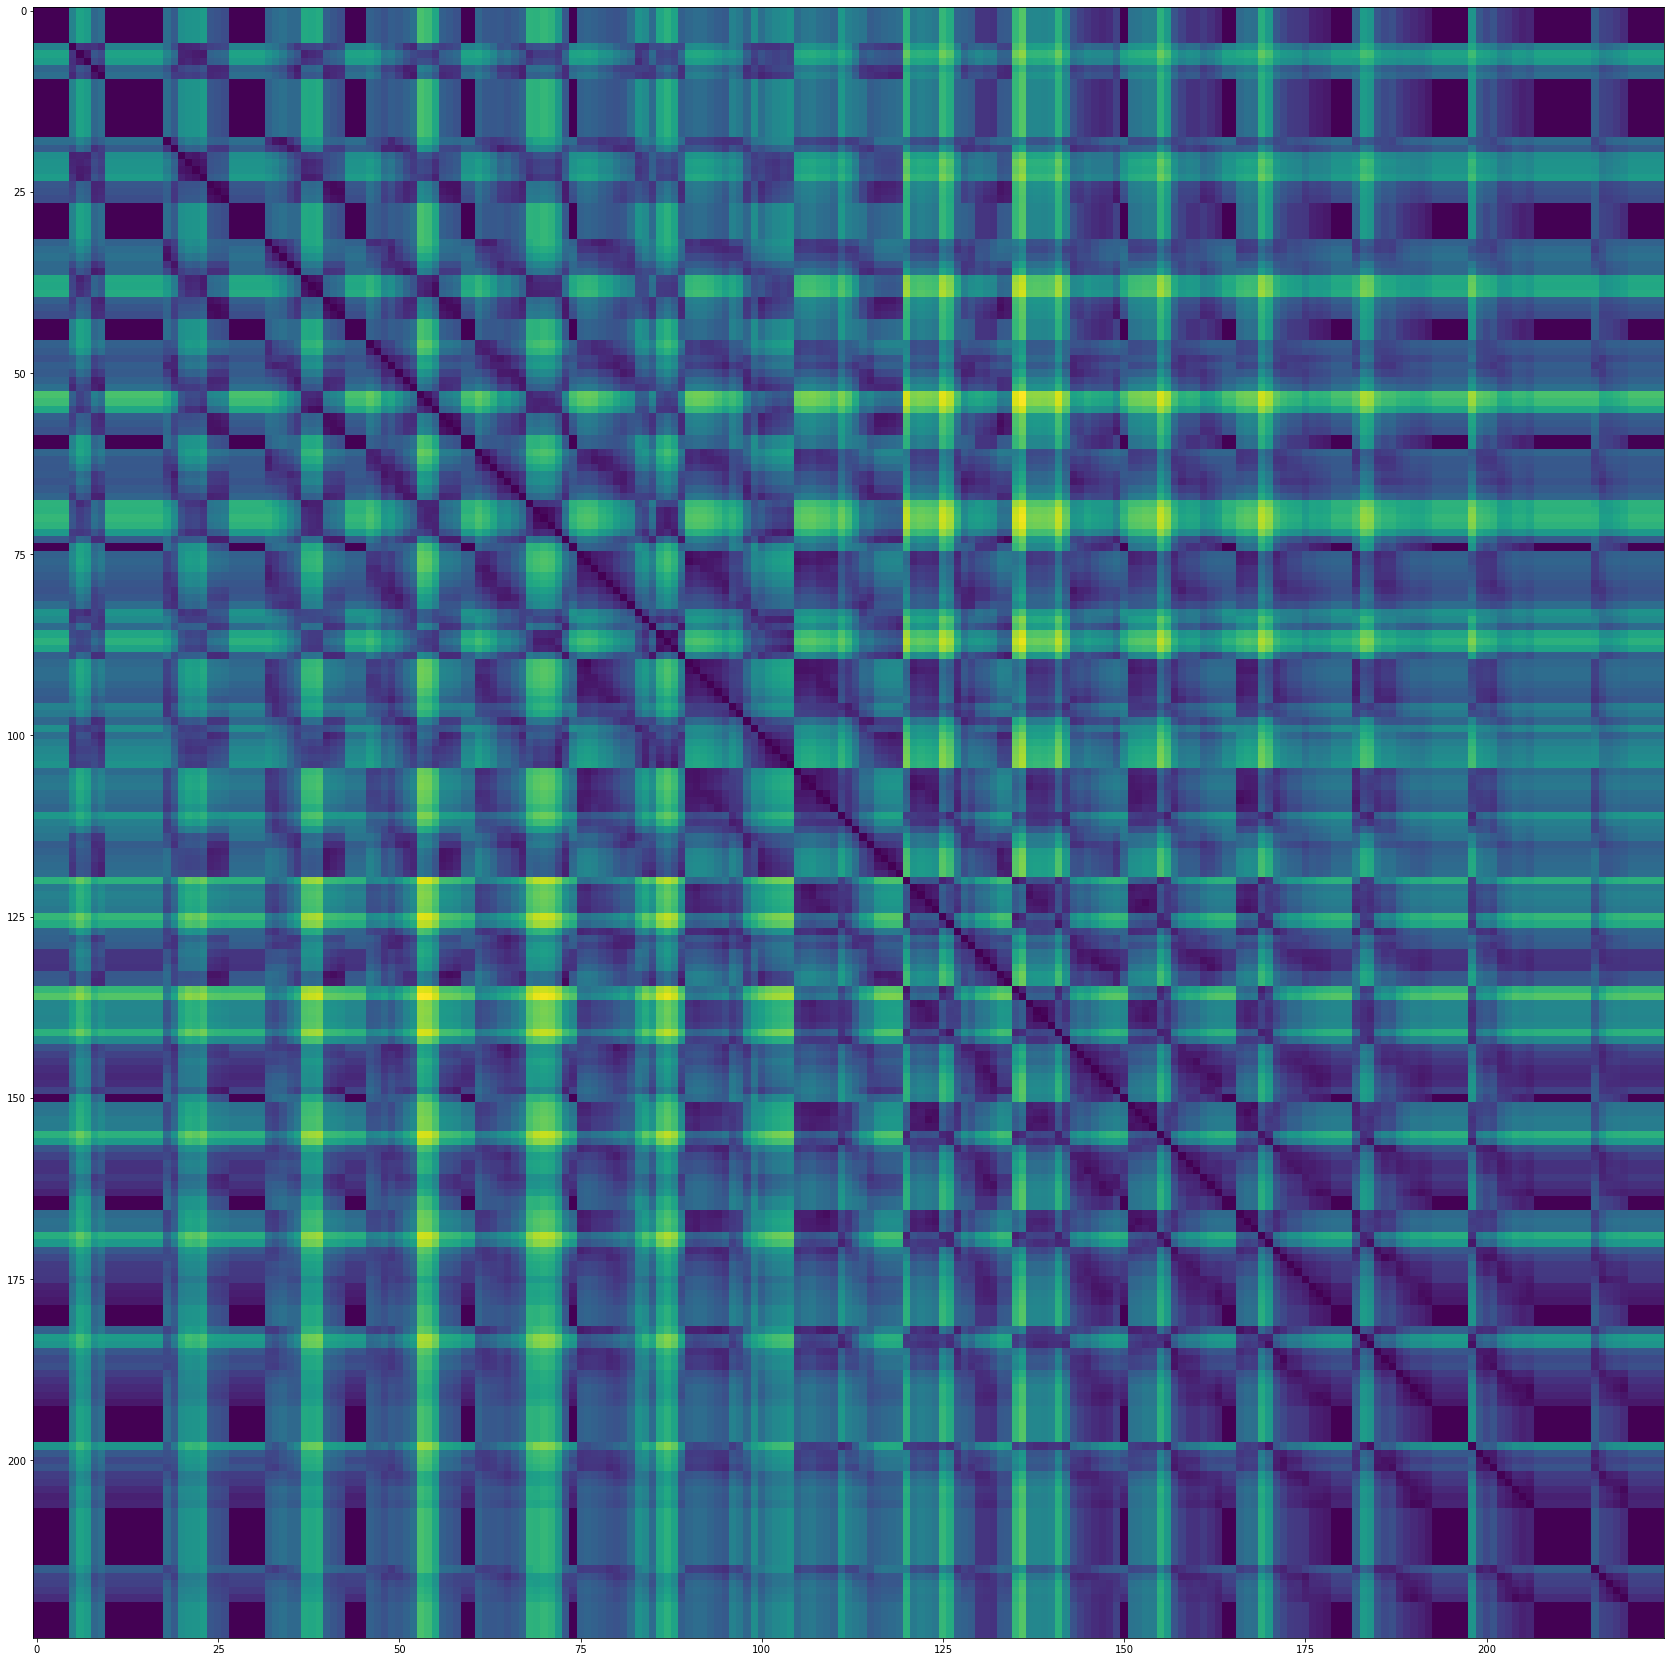

In [1677]:
plt.imshow(csim2)

In [397]:
from PIL import Image
import matplotlib
import matplotlib.cm as cm
import scipy.cluster.vq as scv

In [514]:
arr=plt.imread('/Users/ollie/Downloads/Outlook-xrjjtowh (1).jpg') / 255

alpha = np.ones(arr.shape[:2] + (1,))

arr = np.dstack((arr, alpha))

In [80]:
# def deepmap(lst, func, level):
#     if level <= 0:
#         return func(lst)
#     else:
#         return [deepmap(sub, func, level - 1) for sub in lst]

In [112]:
fitlists[5][5][0]

{'curve 0': {'FWHM': 6.128245897029832,
  'area': 263.29119568175,
  'area_err': 8.88925446415785e-08,
  'x0': 67.80225803342242},
 'curve 1': {'FWHM': 8.144431673157525,
  'area': -36.41986075893227,
  'area_err': 1.7177401563043398e-07,
  'x0': 60.3483420137568},
 'curve 2': {'FWHM': 54.160862705700524,
  'area': -156.49052005748774,
  'area_err': 1.7373937850338776e-12,
  'x0': 62.02320386043732}}

In [ ]:
# def count_bblocks(fitlists, dim = 2):
#     return np.array(deepmap(fitlists, lambda lst: len(lst) if lst is not None else 0, dim))

# def count_peaks(fitlists, dim = 2):
#     npeak_grid2 = np.array(deepmap(fitlists, lambda lst: sum(len(l) for l in lst) if lst is not None else 0, dim))

In [161]:
reload(feat)

<module 'xrdc.featurization' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/featurization.py'>

In [168]:
npeak_grid = feat.count_bblocks(fitlists, 2)

In [169]:
npeak_grid2 = feat.count_peaks(fitlists, 2)

Ground truth

In [ ]:
truth_labels=np.array(list([4,4,4,4,4])+list([4,4,4,4,4,4,4,3,3])+list([4,4,4,4,4,4,4,3,3,3,3])+list([4,4,4,11,4,4,4,4,3,3,3,2,2])+list([4,4,4,11,11,4,4,4,3,3,2,2,1])+list([5,5,4,11,11,11,4,4,5,5,2,2,1,1,1])+list([6,5,5,11,11,11,4,5,5,2,2,1,1,1,1])+list([7,6,5,5,11,11,5,5,2,2,1,1,1,1,1])+list([7,7,6,5,5,5,5,10,10,2,1,1,1,1,1])+list([7,7,6,6,10,10,10,10,10,9,1,1,1,1,1])+list([8,8,6,6,6,6,9,9,9,1,1,1,1])+list([8,8,8,6,9,9,9,9,9,1,1,1,1])+list([8,8,6,9,9,9,9,1,1,1,1])+list([8,6,9,9,9,9,1,1,1])+list([9,9,9,1,1]))
#This part of the code is a savior
new_truth_labels=[None]*177
for ii in range(0,177):
    x,y=d3d.dgrid.coord(ii+1)
    new_grid=d3d.dgrid.grid_num(16-x,y)
    new_truth_labels[new_grid-1]=truth_labels[ii]
y=np.array(new_truth_labels) - 1

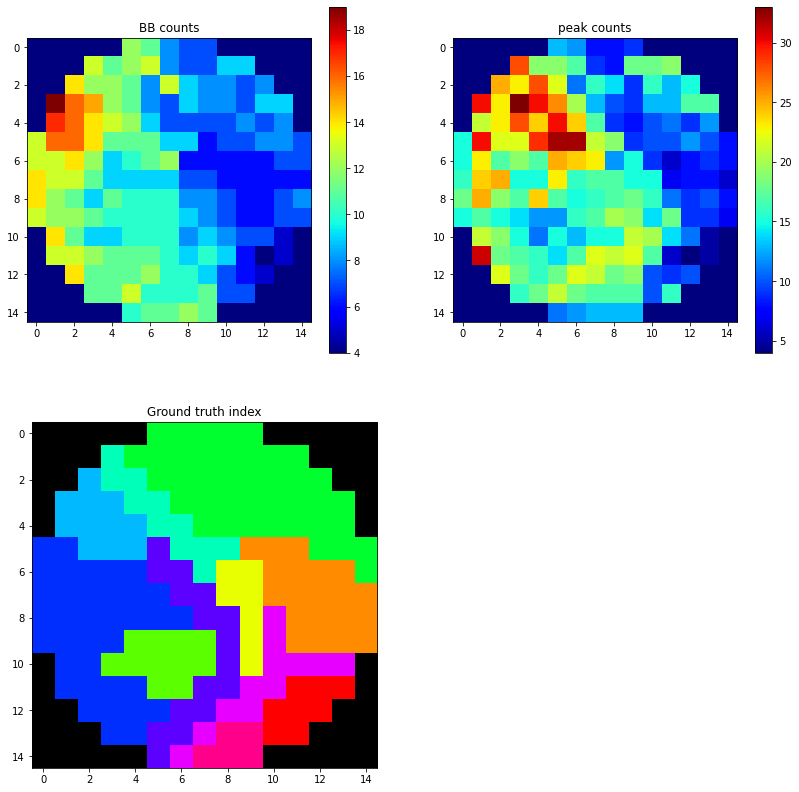

In [170]:
plt.rcParams["figure.figsize"]=(14, 14)
a, b = 2, 2

plt.subplot(a, b, 1)
plt.imshow(npeak_grid, cmap = 'jet')
plt.title('BB counts')
plt.colorbar()

plt.subplot(a, b, 2)
plt.imshow(npeak_grid2, cmap = 'jet')
plt.title('peak counts')
plt.colorbar()

plt.subplot(a, b, 3)
plt.title("Ground truth index")
d3d.plot_clusters_grid(d3d.get_coords(d3d.dgrid), (y + 3) % 11, 11)

In [138]:
Xflat = np.swapaxes(activations_n1, 0, 2)[mask]

_, Xpca = vis.do_pca(Xflat, 3)

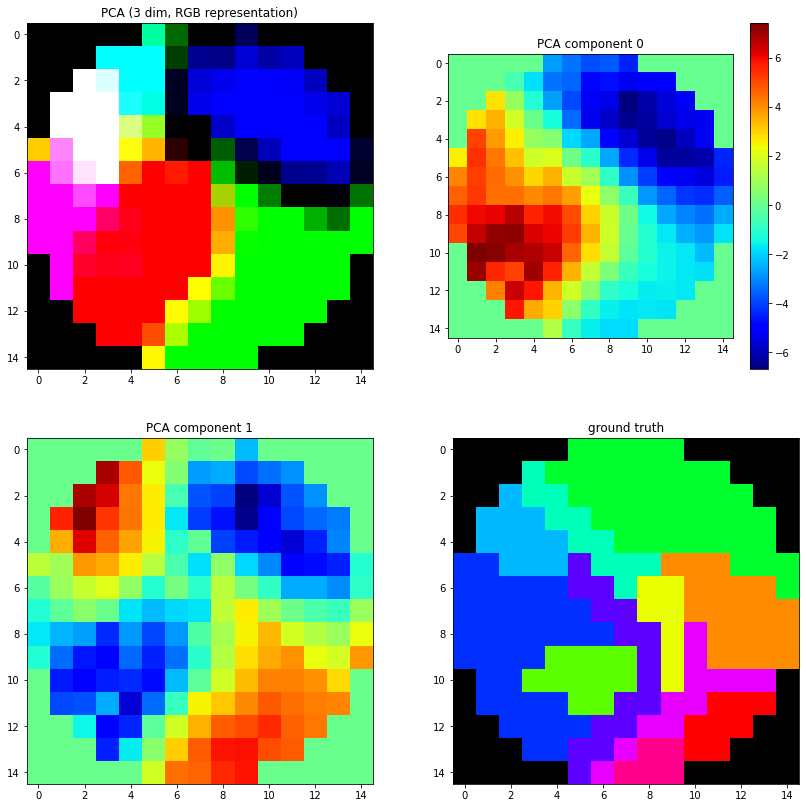

In [157]:
plt.rcParams["figure.figsize"]=(14, 14)
a, b = 2, 2

plt.subplot(a, b, 1)
plt.imshow(d3d.to_3d(Xpca))
plt.title('PCA (3 dim, RGB representation)')

plt.subplot(a, b, 2)
plt.imshow(d3d.to_3d(Xpca)[:, :, 0], cmap = 'jet')
plt.title('PCA component 0')
plt.colorbar()

plt.subplot(a, b, 3)
plt.imshow(d3d.to_3d(Xpca)[:, :, 1], cmap = 'jet')
plt.title('PCA component 1')

plt.subplot(a, b, 4)
plt.title('ground truth')
d3d.plot_clusters_grid(d3d.get_coords(d3d.dgrid), (y + 3) % 11, 11)

